In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Subset

from train import * 
from src.autoencoder import * 
from Data.two_body_dataset import *
from src.gan import *
from src.NN.multi_step_pred import *
from src.LaLiGAN.custom_emlp_laligan import *
from src.NN.custom_emlp_multistep import *

import warnings
warnings.filterwarnings("ignore", message="torch.utils._pytree._register_pytree_node is deprecated")

/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/d_disk/ch20b065/.conda/envs/liegan/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
input_timesteps = 4
output_timesteps = 2
n_dim = 8

train_dataset = TwoBodyDataset(
    save_path='./data/two_body_dataset.pkl',
    input_timesteps = input_timesteps,
    output_timesteps = output_timesteps,
    mode='train'
)

test_dataset = TwoBodyDataset(
    save_path='./data/two_body_dataset.pkl',
    input_timesteps = input_timesteps,
    output_timesteps = output_timesteps,
    mode='test'
)



# Get the actual size of the dataset
train_size = 2000
test_size = 400

# Sample accordingly
train_indices = np.random.choice(len(train_dataset), size=train_size, replace=False)
test_indices = np.random.choice(len(test_dataset), size=test_size, replace=False)


train_dataset = Subset(train_dataset,train_indices)
test_dataset = Subset(test_dataset,test_indices)


In [3]:
class Args:
    def __init__(self):
        # model & training settings
        self.batch_size = 64
        self.num_epochs = 100
        self.lr_d = 2e-4
        self.lr_g = 1e-3
        self.reg_type = 'cosine'
        self.lamda = 1e-2
        self.p_norm = 2
        self.droprate_init = 0.8
        self.mu = 0.0
        self.activate_threshold = False
        self.D_loss_threshold = 0.25
        self.model = 'lie'
        self.coef_dist = 'normal'
        self.g_init = 'random'
        self.sigma_init = 1
        self.uniform_max = 1
        self.normalize_Li = False
        self.augment = False
        self.n_channel = 1
        self.eta = 1.0
        self.incremental = False
        
        # dataset settings
        self.task = 'pendulum'
        self.dataset_name = 'pendulum'
        self.dataset_config = None
        self.dataset_size = 2000
        self.x_type = 'vector'
        self.y_type = 'vector'
        self.input_timesteps = 1
        self.output_timesteps = 1
        self.n_component = 1
        self.noise = 0.0
        
        # run settings
        self.seed = 42
        self.gpu = 0
        self.print_every = 1
        self.save_path = 'saved_model'
        self.save_name = 'default'
        self.device = get_device()

        # regressor

# Create the args object with default values
args = Args()


In [4]:
train_loader = DataLoader(train_dataset,batch_size=args.batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=args.batch_size,shuffle=False)

In [5]:
# Defining the autoencoder
hidden_dim = 128
latent_dim = 12
n_layers = 3 

autoencoder = AutoEncoder(n_dim,hidden_dim,latent_dim,n_layers).to(args.device)

In [6]:
# Defining the generator, discriminator and regressor

n_channel = args.n_channel
generator = LieGenerator(latent_dim,n_channel,args).to(args.device)

d_input_size = latent_dim*(input_timesteps + output_timesteps)
discriminator = LieDiscriminator(d_input_size).to(args.device)

regressor = PredModel(
    n_dim = latent_dim, 
    input_dim = input_timesteps, 
    hidden_dim = hidden_dim, 
    output_dim = output_timesteps
).to(args.device)

In [7]:
w_recon = 2
w_gan = 1
w_reg = 1e-2 
w_chreg = 0 
w_reg_z = 1e-3
w_reg_x = 1
log_interval = 1
save_interval = 100 

reg_type = args.reg_type

num_epochs = 500
batch_size = args.batch_size
lr_ae = 1e-3 
lr_g = 1e-3
lr_d = 1e-3 
lr_reg = 1e-3

device = get_device()
save_dir = 'LaLiGAN/vanilla/two_body'

In [8]:
flatten_input = True 

stats = train_lassi(
   autoencoder, discriminator, generator, train_loader, test_loader,
    num_epochs, lr_ae, lr_d, lr_g, w_recon, w_gan, reg_type, w_reg, w_chreg,
    regressor, lr_reg, w_reg_z, w_reg_x,
    device, save_interval, save_dir
)

Starting training: 500 epochs


  0%|          | 1/500 [00:01<08:29,  1.02s/it]

Epoch 1/500, Train Loss: 0.156088, Test Loss: 0.025564
loss_ae: 0.2546, loss_g: 0.3113, loss_g_reg: 0.9190, loss_g_chreg: 0.0000, loss_d_real: 0.3084, loss_d_fake: 1.3761, loss_ae_rel: 0.4184
Parameter containing:
tensor([[[-0.0165,  0.0462,  0.3002, -0.0938, -0.2094, -0.2357, -0.1411,
          -0.1387, -0.1058,  0.1791, -0.1322,  0.0379],
         [ 0.1817,  0.1127, -0.0641,  0.1484, -0.0137,  0.0102,  0.1365,
           0.1375,  0.1003,  0.0029, -0.0727,  0.0623],
         [ 0.0274, -0.1026,  0.1089, -0.0350,  0.1145,  0.0360,  0.1309,
           0.0781, -0.0077,  0.1317, -0.0958, -0.0090],
         [ 0.0851, -0.0102, -0.3057, -0.0199, -0.0019,  0.0330,  0.1611,
           0.2132, -0.1382,  0.1605,  0.1895,  0.0290],
         [ 0.1638,  0.0568, -0.0107,  0.1192,  0.0622,  0.0945, -0.0163,
           0.1095,  0.0537,  0.1095, -0.1306, -0.0975],
         [ 0.0728, -0.0467,  0.1052,  0.0803, -0.3388,  0.0077, -0.1102,
          -0.0524, -0.0717, -0.0953, -0.0081,  0.1047],
         [ 0

  2%|▏         | 11/500 [00:06<04:33,  1.79it/s]

Epoch 11/500, Train Loss: 0.018986, Test Loss: 0.005654
loss_ae: 0.0237, loss_g: 0.2972, loss_g_reg: 0.9901, loss_g_chreg: 0.0000, loss_d_real: 0.2969, loss_d_fake: 1.3744, loss_ae_rel: 0.0387
Parameter containing:
tensor([[[ 0.0425,  0.1805,  0.2027, -0.0244, -0.2217, -0.1202, -0.0898,
          -0.1865, -0.2210,  0.1237, -0.1107,  0.0863],
         [ 0.1001,  0.1104, -0.0533,  0.1147, -0.0587,  0.0615,  0.1473,
           0.0176,  0.1497,  0.0520, -0.0165,  0.0549],
         [ 0.0861,  0.0097,  0.1634, -0.0331,  0.0713,  0.1688,  0.0961,
           0.0278, -0.0527,  0.0357, -0.0003,  0.0012],
         [ 0.0966,  0.0379, -0.2027,  0.0558, -0.1336,  0.1377,  0.0106,
           0.2576, -0.0433,  0.0618,  0.1885, -0.0041],
         [ 0.0933, -0.0469, -0.0190,  0.1421,  0.1105,  0.0220,  0.0381,
          -0.0152,  0.0567,  0.1512, -0.0389, -0.0531],
         [-0.0355, -0.0904,  0.0603,  0.0810, -0.2380,  0.0702, -0.0484,
          -0.1270, -0.1092, -0.0150,  0.0587,  0.0518],
         [-

  4%|▍         | 21/500 [00:11<04:03,  1.97it/s]

Epoch 21/500, Train Loss: 0.013195, Test Loss: 0.006422
loss_ae: 0.0152, loss_g: 0.2936, loss_g_reg: 0.9971, loss_g_chreg: 0.0000, loss_d_real: 0.2910, loss_d_fake: 1.3768, loss_ae_rel: 0.0249
Parameter containing:
tensor([[[ 0.1834,  0.2328,  0.1493,  0.1026, -0.2065, -0.1263, -0.0892,
          -0.1397, -0.2613, -0.0130, -0.1599,  0.1279],
         [ 0.0191,  0.0772, -0.0089,  0.0424, -0.0805,  0.0806,  0.1123,
          -0.0224,  0.1569,  0.1293,  0.0207,  0.0151],
         [ 0.0746, -0.0377,  0.1472, -0.0968,  0.0335,  0.1607,  0.0865,
          -0.0175, -0.0129,  0.0709, -0.0112,  0.0074],
         [-0.0017, -0.0312, -0.1754,  0.0035, -0.0865,  0.0738,  0.0078,
           0.2952, -0.0643,  0.1479,  0.0232,  0.0912],
         [ 0.0876, -0.0850, -0.0289,  0.1008,  0.1380, -0.0248,  0.0524,
          -0.0815,  0.0015,  0.1173,  0.0593,  0.0247],
         [-0.0300, -0.0914,  0.0977,  0.0440, -0.2329,  0.0537, -0.0797,
          -0.0468, -0.0570, -0.0314, -0.0420,  0.0917],
         [ 

  6%|▌         | 31/500 [00:17<05:48,  1.34it/s]

Epoch 31/500, Train Loss: 0.010797, Test Loss: 0.004806
loss_ae: 0.0114, loss_g: 0.2932, loss_g_reg: 0.9987, loss_g_chreg: 0.0000, loss_d_real: 0.2930, loss_d_fake: 1.3776, loss_ae_rel: 0.0187
Parameter containing:
tensor([[[ 0.1847,  0.2307,  0.1436,  0.0832, -0.1961, -0.1204, -0.1073,
          -0.1495, -0.2681, -0.0056, -0.1230,  0.1352],
         [ 0.0478,  0.0819, -0.0225,  0.0458, -0.0690,  0.0875,  0.1014,
          -0.0206,  0.1452,  0.0958,  0.0482,  0.0249],
         [ 0.0269, -0.0492,  0.1630, -0.0855,  0.0195,  0.1441,  0.0961,
          -0.0109,  0.0028,  0.1125, -0.0812, -0.0054],
         [ 0.0257, -0.0328, -0.1801,  0.0698, -0.0839,  0.0545,  0.0585,
           0.3326, -0.0636,  0.1135, -0.0542,  0.0853],
         [ 0.1094, -0.0339,  0.0169,  0.0674,  0.0904,  0.0264,  0.0331,
          -0.0460,  0.0564,  0.0857,  0.0467, -0.0140],
         [ 0.0172, -0.0615,  0.1021,  0.0328, -0.2335,  0.0789, -0.0782,
          -0.0317, -0.0429, -0.0857, -0.0177,  0.0853],
         [ 

  8%|▊         | 41/500 [00:23<04:13,  1.81it/s]

Epoch 41/500, Train Loss: 0.012269, Test Loss: 0.005170
loss_ae: 0.0136, loss_g: 0.2891, loss_g_reg: 0.9971, loss_g_chreg: 0.0000, loss_d_real: 0.2899, loss_d_fake: 1.3850, loss_ae_rel: 0.0220
Parameter containing:
tensor([[[ 0.1721,  0.2354,  0.1486,  0.0516, -0.1862, -0.0968, -0.1385,
          -0.1442, -0.2608,  0.0070, -0.0995,  0.1476],
         [ 0.1138,  0.1160, -0.0427,  0.0261, -0.0543,  0.1073,  0.0930,
          -0.0170,  0.1154,  0.0353,  0.0784,  0.0258],
         [ 0.0460, -0.0579,  0.1563, -0.0719,  0.0104,  0.1265,  0.1240,
          -0.0121,  0.0013,  0.0904, -0.1011, -0.0128],
         [ 0.0194, -0.0463, -0.1890,  0.0757, -0.0836,  0.0320,  0.0720,
           0.3059, -0.0728,  0.1186, -0.0573,  0.0856],
         [ 0.1049, -0.0257,  0.0171,  0.0327,  0.0960,  0.0316,  0.0218,
          -0.0478,  0.0585,  0.0737,  0.0678, -0.0064],
         [ 0.0203, -0.0519,  0.0963,  0.0069, -0.2190,  0.0890, -0.0891,
          -0.0328, -0.0456, -0.0925,  0.0011,  0.0977],
         [ 

 10%|█         | 51/500 [00:28<03:34,  2.09it/s]

Epoch 51/500, Train Loss: 0.009608, Test Loss: 0.002806
loss_ae: 0.0100, loss_g: 0.2923, loss_g_reg: 0.9967, loss_g_chreg: 0.0000, loss_d_real: 0.2916, loss_d_fake: 1.3818, loss_ae_rel: 0.0164
Parameter containing:
tensor([[[ 0.1457,  0.1980,  0.1315,  0.0863, -0.1320, -0.0993, -0.1533,
          -0.1390, -0.2796,  0.0498, -0.0596,  0.2121],
         [ 0.1128,  0.1245, -0.0225,  0.0077, -0.0748,  0.1115,  0.0748,
          -0.0021,  0.1301,  0.0360,  0.0604,  0.0070],
         [ 0.0397, -0.0431,  0.1701, -0.0864, -0.0091,  0.1258,  0.1257,
          -0.0073,  0.0207,  0.0834, -0.1119, -0.0276],
         [-0.0166, -0.0371, -0.1500,  0.0459, -0.1296,  0.0104,  0.0873,
           0.2896, -0.0181,  0.1074, -0.0950,  0.0593],
         [ 0.0836,  0.0133,  0.0395, -0.0018,  0.0881,  0.0565,  0.0059,
          -0.0356,  0.0721,  0.0493,  0.0576, -0.0092],
         [ 0.0270, -0.0155,  0.1013, -0.0164, -0.1994,  0.1174, -0.0964,
          -0.0164, -0.0437, -0.1136,  0.0144,  0.1013],
         [ 

 12%|█▏        | 61/500 [00:33<03:28,  2.10it/s]

Epoch 61/500, Train Loss: 0.007788, Test Loss: 0.004196
loss_ae: 0.0081, loss_g: 0.2915, loss_g_reg: 0.9982, loss_g_chreg: 0.0000, loss_d_real: 0.2899, loss_d_fake: 1.3827, loss_ae_rel: 0.0132
Parameter containing:
tensor([[[ 0.1000,  0.1871,  0.1617,  0.0979, -0.1226, -0.0981, -0.1644,
          -0.1214, -0.2333,  0.0578, -0.0658,  0.2223],
         [ 0.1195,  0.1490, -0.0083, -0.0101, -0.0747,  0.1154,  0.0796,
          -0.0076,  0.1339,  0.0153,  0.0478, -0.0083],
         [ 0.0328, -0.0756,  0.1628, -0.0671, -0.0186,  0.0953,  0.1240,
          -0.0066,  0.0249,  0.0991, -0.1129, -0.0276],
         [-0.0415, -0.0190, -0.1132,  0.0244, -0.1447,  0.0135,  0.0986,
           0.2734,  0.0158,  0.0931, -0.1124,  0.0500],
         [ 0.0501,  0.0156,  0.0559, -0.0115,  0.0785,  0.0391,  0.0164,
          -0.0449,  0.0922,  0.0432,  0.0437, -0.0133],
         [ 0.0295,  0.0163,  0.1044, -0.0267, -0.1678,  0.1761, -0.1210,
           0.0061, -0.0515, -0.1181,  0.0243,  0.1191],
         [ 

 14%|█▍        | 71/500 [00:38<03:28,  2.05it/s]

Epoch 71/500, Train Loss: 0.007048, Test Loss: 0.002939
loss_ae: 0.0069, loss_g: 0.2905, loss_g_reg: 0.9978, loss_g_chreg: 0.0000, loss_d_real: 0.2895, loss_d_fake: 1.3827, loss_ae_rel: 0.0111
Parameter containing:
tensor([[[ 8.3705e-02,  1.7385e-01,  1.8019e-01,  1.0369e-01, -1.1786e-01,
          -1.2159e-01, -1.6277e-01, -1.2176e-01, -1.9915e-01,  5.8364e-02,
          -7.0232e-02,  2.2052e-01],
         [ 1.4690e-01,  1.5639e-01, -3.5520e-02, -1.8555e-02, -7.0933e-02,
           1.2653e-01,  7.5042e-02, -7.8706e-03,  9.5536e-02,  2.2131e-02,
           6.2267e-02, -1.6476e-03],
         [ 4.8018e-02, -8.1467e-02,  1.4336e-01, -6.6867e-02, -2.0228e-02,
           9.3001e-02,  1.2403e-01, -9.0061e-03,  6.8047e-04,  1.0638e-01,
          -1.0198e-01, -2.5004e-02],
         [-7.1635e-02, -6.4852e-02, -7.7805e-02,  5.9030e-02, -1.5172e-01,
          -3.3962e-02,  8.8812e-02,  2.6164e-01,  7.8494e-02,  1.0041e-01,
          -1.2455e-01,  4.6184e-02],
         [ 4.7294e-02,  4.3681e-02,  

 16%|█▌        | 81/500 [00:43<04:00,  1.74it/s]

Epoch 81/500, Train Loss: 0.006731, Test Loss: 0.003614
loss_ae: 0.0068, loss_g: 0.2917, loss_g_reg: 0.9977, loss_g_chreg: 0.0000, loss_d_real: 0.2906, loss_d_fake: 1.3840, loss_ae_rel: 0.0111
Parameter containing:
tensor([[[ 0.0858,  0.1678,  0.2037,  0.1219, -0.1403, -0.1378, -0.1406,
          -0.1471, -0.1469,  0.0368, -0.0931,  0.1827],
         [ 0.1470,  0.1248, -0.0472, -0.0109, -0.0573,  0.1003,  0.0442,
          -0.0016,  0.0802,  0.0515,  0.0870,  0.0146],
         [ 0.0446, -0.0955,  0.1394, -0.0603, -0.0149,  0.0946,  0.1097,
           0.0033, -0.0020,  0.1219, -0.0902, -0.0155],
         [-0.0641, -0.0678, -0.0893,  0.0495, -0.1484, -0.0603,  0.0955,
           0.2392,  0.0721,  0.0936, -0.1132,  0.0506],
         [ 0.0562,  0.0246,  0.0151, -0.0223,  0.0954,  0.0838, -0.0077,
          -0.0329,  0.0350,  0.0689,  0.0698,  0.0264],
         [ 0.0163,  0.0080,  0.1057, -0.0423, -0.1533,  0.1523, -0.1082,
          -0.0065, -0.0282, -0.1190,  0.0307,  0.1215],
         [ 

 18%|█▊        | 91/500 [00:48<03:28,  1.96it/s]

Epoch 91/500, Train Loss: 0.007082, Test Loss: 0.002905
loss_ae: 0.0069, loss_g: 0.2896, loss_g_reg: 0.9976, loss_g_chreg: 0.0000, loss_d_real: 0.2891, loss_d_fake: 1.3848, loss_ae_rel: 0.0109
Parameter containing:
tensor([[[ 0.0921,  0.1613,  0.2161,  0.1297, -0.1172, -0.1554, -0.1119,
          -0.1607, -0.1137,  0.0214, -0.0983,  0.1714],
         [ 0.1560,  0.1523, -0.0515, -0.0355, -0.0811,  0.1190,  0.0422,
          -0.0075,  0.0556,  0.0486,  0.0736,  0.0056],
         [ 0.0497, -0.0808,  0.1437, -0.0638, -0.0343,  0.1031,  0.1060,
           0.0042, -0.0022,  0.1180, -0.1073, -0.0273],
         [-0.0697, -0.0546, -0.0751,  0.0436, -0.1411, -0.0404,  0.1043,
           0.2407,  0.0818,  0.0809, -0.1149,  0.0553],
         [ 0.0538,  0.0248,  0.0185, -0.0184,  0.0943,  0.0748, -0.0084,
          -0.0385,  0.0503,  0.0693,  0.0622,  0.0222],
         [ 0.0179, -0.0205,  0.0877, -0.0316, -0.1304,  0.1157, -0.0915,
          -0.0190, -0.0233, -0.1137,  0.0381,  0.1266],
         [ 

 20%|██        | 101/500 [00:54<03:38,  1.83it/s]

Epoch 101/500, Train Loss: 0.007098, Test Loss: 0.004579
loss_ae: 0.0065, loss_g: 0.2898, loss_g_reg: 0.9985, loss_g_chreg: 0.0000, loss_d_real: 0.2890, loss_d_fake: 1.3825, loss_ae_rel: 0.0106
Parameter containing:
tensor([[[ 0.0791,  0.1455,  0.1955,  0.1465, -0.0912, -0.1593, -0.0905,
          -0.1553, -0.1233,  0.0305, -0.0831,  0.1960],
         [ 0.1500,  0.1608, -0.0601, -0.0464, -0.0889,  0.1147,  0.0504,
          -0.0177,  0.0385,  0.0443,  0.0719,  0.0031],
         [ 0.0575, -0.0836,  0.1538, -0.0585, -0.0432,  0.1012,  0.0890,
           0.0100,  0.0133,  0.1214, -0.1139, -0.0413],
         [-0.0712, -0.0453, -0.0438,  0.0442, -0.1408, -0.0216,  0.0985,
           0.2375,  0.1125,  0.0584, -0.1206,  0.0446],
         [ 0.0656,  0.0088,  0.0249, -0.0096,  0.0855,  0.0539, -0.0229,
          -0.0412,  0.0698,  0.0639,  0.0506,  0.0053],
         [-0.0094, -0.0115,  0.0641, -0.0384, -0.1104,  0.1579, -0.0773,
          -0.0079, -0.0701, -0.0849,  0.0636,  0.1720],
         [

 22%|██▏       | 111/500 [00:59<03:08,  2.07it/s]

Epoch 111/500, Train Loss: 0.006506, Test Loss: 0.002301
loss_ae: 0.0060, loss_g: 0.2897, loss_g_reg: 0.9990, loss_g_chreg: 0.0000, loss_d_real: 0.2886, loss_d_fake: 1.3864, loss_ae_rel: 0.0098
Parameter containing:
tensor([[[ 0.0632,  0.1279,  0.2094,  0.1758, -0.0740, -0.1302, -0.1145,
          -0.1364, -0.1067,  0.0430, -0.0652,  0.1967],
         [ 0.1439,  0.1467, -0.0600, -0.0394, -0.0906,  0.1047,  0.0511,
          -0.0163,  0.0577,  0.0531,  0.0671,  0.0004],
         [ 0.0617, -0.0657,  0.1485, -0.0709, -0.0517,  0.0993,  0.0952,
           0.0016, -0.0026,  0.1142, -0.1157, -0.0426],
         [-0.0913, -0.0330, -0.0296,  0.0482, -0.1340,  0.0260,  0.0735,
           0.2509,  0.1154,  0.0618, -0.1046,  0.0519],
         [ 0.0637,  0.0214,  0.0124, -0.0247,  0.0867,  0.0621, -0.0117,
          -0.0463,  0.0456,  0.0680,  0.0506,  0.0229],
         [-0.0048, -0.0327,  0.0726, -0.0209, -0.1113,  0.1422, -0.0884,
          -0.0054, -0.0445, -0.0826,  0.0597,  0.1506],
         [

 24%|██▍       | 121/500 [01:03<03:05,  2.04it/s]

Epoch 121/500, Train Loss: 0.006114, Test Loss: 0.002471
loss_ae: 0.0056, loss_g: 0.2896, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.2894, loss_d_fake: 1.3865, loss_ae_rel: 0.0092
Parameter containing:
tensor([[[ 0.0700,  0.1171,  0.2044,  0.1708, -0.0792, -0.1535, -0.1175,
          -0.1394, -0.1008,  0.0464, -0.0718,  0.1905],
         [ 0.1399,  0.1671, -0.0653, -0.0464, -0.0947,  0.1172,  0.0567,
          -0.0210,  0.0364,  0.0549,  0.0701,  0.0101],
         [ 0.0522, -0.0970,  0.1690, -0.0576, -0.0451,  0.0960,  0.0756,
           0.0117,  0.0302,  0.1174, -0.1111, -0.0504],
         [-0.0851, -0.0058, -0.0107,  0.0339, -0.1383,  0.0513,  0.0718,
           0.2323,  0.1059,  0.0484, -0.1026,  0.0411],
         [ 0.0493,  0.0026,  0.0140, -0.0165,  0.0957,  0.0675, -0.0275,
          -0.0297,  0.0520,  0.0760,  0.0580,  0.0312],
         [-0.0089, -0.0503,  0.0544, -0.0011, -0.1041,  0.1379, -0.0924,
          -0.0009, -0.0368, -0.0571,  0.0660,  0.1500],
         [

 26%|██▌       | 131/500 [01:09<03:12,  1.92it/s]

Epoch 131/500, Train Loss: 0.006266, Test Loss: 0.001916
loss_ae: 0.0052, loss_g: 0.2896, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.2892, loss_d_fake: 1.3863, loss_ae_rel: 0.0086
Parameter containing:
tensor([[[ 8.0605e-02,  1.2241e-01,  1.9443e-01,  1.6212e-01, -8.6264e-02,
          -1.6999e-01, -1.0973e-01, -1.4719e-01, -1.0826e-01,  4.7169e-02,
          -7.2911e-02,  1.8363e-01],
         [ 1.1853e-01,  1.2039e-01, -4.4386e-02, -2.2015e-02, -6.8616e-02,
           1.1755e-01,  2.5280e-02,  1.4698e-03,  7.6901e-02,  6.8010e-02,
           7.2534e-02,  1.2352e-02],
         [ 7.6805e-02, -1.0395e-01,  1.5800e-01, -6.3727e-02, -4.5157e-02,
           5.8339e-02,  8.2139e-02,  2.1756e-03,  3.4231e-02,  1.2764e-01,
          -1.1040e-01, -5.4416e-02],
         [-7.2275e-02, -7.2008e-03, -1.5957e-02,  2.8569e-02, -1.3654e-01,
           3.3391e-02,  7.4623e-02,  2.2645e-01,  1.0972e-01,  4.9832e-02,
          -1.0448e-01,  3.6796e-02],
         [ 3.0213e-02,  5.5153e-04, 

 28%|██▊       | 141/500 [01:14<03:05,  1.94it/s]

Epoch 141/500, Train Loss: 0.005810, Test Loss: 0.001943
loss_ae: 0.0051, loss_g: 0.2876, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.2871, loss_d_fake: 1.3903, loss_ae_rel: 0.0083
Parameter containing:
tensor([[[ 1.0795e-01,  1.2904e-01,  1.9548e-01,  1.4382e-01, -1.0881e-01,
          -1.9899e-01, -9.9605e-02, -1.6406e-01, -9.9840e-02,  2.6035e-02,
          -8.7974e-02,  1.5483e-01],
         [ 1.1634e-01,  1.5499e-01, -6.6486e-02, -3.6902e-02, -8.9712e-02,
           1.2403e-01,  1.9225e-02, -1.2359e-02,  4.9763e-02,  5.7917e-02,
           7.0399e-02,  1.5993e-02],
         [ 8.0100e-02, -1.3025e-01,  1.7627e-01, -5.0141e-02, -3.7976e-02,
           4.4166e-02,  6.6494e-02,  1.2794e-02,  6.4776e-02,  1.3525e-01,
          -1.1121e-01, -6.5343e-02],
         [-5.9130e-02, -1.6350e-02, -3.6669e-02,  2.7124e-02, -1.2048e-01,
           6.1435e-03,  9.0424e-02,  2.1839e-01,  1.0442e-01,  6.4080e-02,
          -8.7359e-02,  4.8869e-02],
         [ 4.8717e-02,  2.1071e-02, 

 30%|███       | 151/500 [01:19<02:43,  2.14it/s]

Epoch 151/500, Train Loss: 0.005655, Test Loss: 0.002118
loss_ae: 0.0051, loss_g: 0.2883, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.2877, loss_d_fake: 1.3882, loss_ae_rel: 0.0083
Parameter containing:
tensor([[[ 0.0911,  0.1158,  0.1699,  0.1608, -0.0841, -0.1776, -0.1011,
          -0.1539, -0.1129,  0.0463, -0.0718,  0.1766],
         [ 0.1283,  0.1532, -0.0654, -0.0360, -0.0962,  0.1164,  0.0037,
          -0.0093,  0.0482,  0.0642,  0.0684,  0.0051],
         [ 0.0777, -0.1093,  0.1545, -0.0553, -0.0384,  0.0584,  0.0703,
           0.0069,  0.0438,  0.1421, -0.1053, -0.0606],
         [-0.0733, -0.0167, -0.0452,  0.0285, -0.1112,  0.0215,  0.0928,
           0.2274,  0.0931,  0.0765, -0.0717,  0.0657],
         [ 0.0474,  0.0287,  0.0172, -0.0215,  0.0678,  0.0892, -0.0382,
          -0.0327,  0.0463,  0.0478,  0.0445,  0.0155],
         [-0.0084, -0.0452,  0.0404, -0.0138, -0.1016,  0.1266, -0.0751,
          -0.0057, -0.0541, -0.0540,  0.0681,  0.1548],
         [

 32%|███▏      | 161/500 [01:24<02:46,  2.03it/s]

Epoch 161/500, Train Loss: 0.006007, Test Loss: 0.003027
loss_ae: 0.0049, loss_g: 0.2888, loss_g_reg: 0.9994, loss_g_chreg: 0.0000, loss_d_real: 0.2892, loss_d_fake: 1.3889, loss_ae_rel: 0.0081
Parameter containing:
tensor([[[ 0.0943,  0.1222,  0.1875,  0.1598, -0.0795, -0.1685, -0.1020,
          -0.1454, -0.0987,  0.0481, -0.0737,  0.1576],
         [ 0.1218,  0.1456, -0.0541, -0.0298, -0.0948,  0.1091,  0.0010,
          -0.0049,  0.0606,  0.0600,  0.0685,  0.0007],
         [ 0.0743, -0.1121,  0.1388, -0.0561, -0.0382,  0.0554,  0.0706,
           0.0062,  0.0313,  0.1516, -0.1017, -0.0506],
         [-0.0691, -0.0051, -0.0427,  0.0162, -0.1199,  0.0162,  0.1031,
           0.2205,  0.0880,  0.0706, -0.0775,  0.0540],
         [ 0.0233,  0.0277, -0.0007, -0.0280,  0.0741,  0.0916, -0.0276,
          -0.0274,  0.0314,  0.0608,  0.0575,  0.0347],
         [-0.0006, -0.0475,  0.0606, -0.0121, -0.1060,  0.1162, -0.0796,
          -0.0025, -0.0369, -0.0645,  0.0618,  0.1401],
         [

 34%|███▍      | 171/500 [01:29<03:10,  1.73it/s]

Epoch 171/500, Train Loss: 0.005143, Test Loss: 0.001885
loss_ae: 0.0043, loss_g: 0.2899, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.2898, loss_d_fake: 1.3842, loss_ae_rel: 0.0069
Parameter containing:
tensor([[[ 8.6830e-02,  1.3132e-01,  1.8723e-01,  1.5229e-01, -8.0190e-02,
          -1.5831e-01, -9.3238e-02, -1.4182e-01, -1.0278e-01,  4.7262e-02,
          -6.9392e-02,  1.5856e-01],
         [ 1.1753e-01,  1.3942e-01, -6.2689e-02, -2.8975e-02, -9.1060e-02,
           1.0490e-01,  4.5895e-04, -8.6551e-03,  5.3057e-02,  5.8675e-02,
           7.0981e-02,  1.4732e-02],
         [ 7.3177e-02, -1.0911e-01,  1.2950e-01, -6.2817e-02, -4.1699e-02,
           4.8574e-02,  7.3514e-02, -1.0235e-04,  2.5292e-02,  1.4653e-01,
          -1.0654e-01, -4.5731e-02],
         [-6.8670e-02, -1.7694e-02, -4.0071e-02,  2.9819e-02, -1.1274e-01,
           1.2890e-02,  9.3961e-02,  2.2889e-01,  9.2751e-02,  7.3442e-02,
          -7.6474e-02,  5.5034e-02],
         [ 2.6786e-02,  3.0925e-02, 

 36%|███▌      | 181/500 [01:35<02:48,  1.90it/s]

Epoch 181/500, Train Loss: 0.005295, Test Loss: 0.001855
loss_ae: 0.0045, loss_g: 0.2884, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.2886, loss_d_fake: 1.3876, loss_ae_rel: 0.0074
Parameter containing:
tensor([[[ 0.0977,  0.1443,  0.1914,  0.1397, -0.0871, -0.1663, -0.0855,
          -0.1464, -0.1008,  0.0389, -0.0848,  0.1471],
         [ 0.1436,  0.0845, -0.0005,  0.0336, -0.0670,  0.0643, -0.0419,
           0.0353,  0.1506,  0.0389,  0.0321, -0.0291],
         [ 0.0677, -0.1195,  0.1223, -0.0575, -0.0370,  0.0428,  0.0732,
           0.0036,  0.0204,  0.1620, -0.1013, -0.0381],
         [-0.0572, -0.0013, -0.0584,  0.0006, -0.1359, -0.0028,  0.1146,
           0.1996,  0.0688,  0.0662, -0.0839,  0.0545],
         [ 0.0246,  0.0171,  0.0195, -0.0148,  0.0844,  0.0675, -0.0232,
          -0.0091,  0.0665,  0.0466,  0.0386,  0.0301],
         [ 0.0088, -0.0125,  0.0992, -0.0144, -0.1024,  0.1492, -0.0946,
          -0.0059, -0.0104, -0.0905,  0.0518,  0.1065],
         [

 38%|███▊      | 191/500 [01:40<02:28,  2.07it/s]

Epoch 191/500, Train Loss: 0.005491, Test Loss: 0.002467
loss_ae: 0.0046, loss_g: 0.2888, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.2894, loss_d_fake: 1.3863, loss_ae_rel: 0.0076
Parameter containing:
tensor([[[ 0.1111,  0.1330,  0.1814,  0.1490, -0.0948, -0.1894, -0.0730,
          -0.1391, -0.1033,  0.0356, -0.0981,  0.1361],
         [ 0.1677,  0.0671, -0.0386,  0.0230, -0.1058,  0.0190,  0.0055,
           0.0167,  0.1206,  0.0214,  0.0138, -0.0399],
         [ 0.0779, -0.1142,  0.1486, -0.0634, -0.0209,  0.0445,  0.0564,
          -0.0044,  0.0498,  0.1540, -0.1063, -0.0482],
         [-0.0589,  0.0310,  0.0114,  0.0058, -0.0895,  0.0395,  0.0739,
           0.2032,  0.1354,  0.0433, -0.1004,  0.0227],
         [ 0.0650,  0.0311,  0.0165, -0.0438,  0.0630,  0.0443, -0.0054,
          -0.0375,  0.0678,  0.0146,  0.0104, -0.0032],
         [ 0.0115, -0.0174,  0.0576, -0.0198, -0.1404,  0.1333, -0.0549,
          -0.0105, -0.0555, -0.0889,  0.0452,  0.1026],
         [

 40%|████      | 201/500 [01:45<02:43,  1.83it/s]

Epoch 201/500, Train Loss: 0.005269, Test Loss: 0.002255
loss_ae: 0.0047, loss_g: 0.2883, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2883, loss_d_fake: 1.3870, loss_ae_rel: 0.0075
Parameter containing:
tensor([[[ 0.1068,  0.1386,  0.1644,  0.1391, -0.1068, -0.1941, -0.0596,
          -0.1414, -0.1211,  0.0339, -0.1020,  0.1399],
         [ 0.1603,  0.0405, -0.0315,  0.0583, -0.0945,  0.0144,  0.0114,
           0.0269,  0.1222,  0.0290,  0.0245, -0.0352],
         [ 0.0628, -0.0882,  0.1488, -0.0810, -0.0233,  0.0629,  0.0562,
          -0.0109,  0.0395,  0.1602, -0.0983, -0.0368],
         [-0.0376,  0.0328,  0.0335, -0.0085, -0.0782,  0.0492,  0.0432,
           0.1965,  0.1693,  0.0328, -0.1090,  0.0041],
         [ 0.0672,  0.0130, -0.0021, -0.0315,  0.0473,  0.0230,  0.0082,
          -0.0256,  0.0548,  0.0102,  0.0034, -0.0019],
         [ 0.0007, -0.0308,  0.0410,  0.0005, -0.1514,  0.1242, -0.0411,
          -0.0027, -0.0772, -0.0822,  0.0489,  0.1124],
         [

 42%|████▏     | 211/500 [01:50<02:29,  1.94it/s]

Epoch 211/500, Train Loss: 0.004829, Test Loss: 0.001719
loss_ae: 0.0040, loss_g: 0.2883, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2875, loss_d_fake: 1.3873, loss_ae_rel: 0.0065
Parameter containing:
tensor([[[ 1.0989e-01,  8.2997e-02,  2.3403e-01,  1.8427e-01, -5.7232e-02,
          -1.8284e-01, -9.1927e-02, -1.1507e-01, -6.2462e-02,  5.0850e-02,
          -9.7153e-02,  1.5049e-01],
         [ 1.2923e-01,  1.5895e-01, -3.7665e-02,  3.8626e-02, -6.8432e-02,
           1.0487e-01, -1.5913e-02, -8.5896e-03,  1.1506e-01, -2.8942e-02,
           1.9519e-02, -3.1275e-02],
         [ 5.9206e-02, -3.3649e-02,  1.1292e-01, -7.4133e-02, -5.4355e-02,
           6.9412e-02,  6.2850e-02, -3.6317e-02, -2.0166e-03,  1.3198e-01,
          -1.0263e-01, -3.4012e-02],
         [-7.9539e-04,  5.0880e-02,  7.3516e-03, -3.2229e-02, -8.4235e-02,
           6.0572e-02,  2.6522e-02,  1.7789e-01,  1.7001e-01,  1.4947e-02,
          -1.3214e-01, -1.5273e-02],
         [ 5.9053e-02, -2.9550e-02, 

 44%|████▍     | 221/500 [01:55<02:12,  2.10it/s]

Epoch 221/500, Train Loss: 0.005729, Test Loss: 0.002401
loss_ae: 0.0048, loss_g: 0.2889, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2905, loss_d_fake: 1.3853, loss_ae_rel: 0.0079
Parameter containing:
tensor([[[ 1.1165e-01,  1.1597e-01,  1.8501e-01,  1.2862e-01, -9.7138e-02,
          -1.7384e-01, -7.2884e-02, -1.0288e-01, -1.0791e-01,  5.0012e-02,
          -7.7019e-02,  1.5839e-01],
         [ 1.2210e-01,  1.5241e-01, -1.0240e-01, -4.3945e-02, -1.4038e-01,
           5.7231e-02,  2.7944e-02, -2.8645e-02,  4.6936e-02,  2.6999e-03,
           2.6078e-02, -1.4299e-02],
         [ 9.3812e-02, -3.8552e-02,  1.5968e-01, -7.8691e-02, -5.8366e-02,
           6.5958e-02,  5.6229e-02, -5.1106e-02,  2.1561e-02,  1.0420e-01,
          -1.3997e-01, -5.3493e-02],
         [-2.2370e-02,  2.5836e-02, -5.0007e-03, -3.6496e-02, -9.0251e-02,
           7.0313e-02,  1.9514e-02,  2.1750e-01,  1.7509e-01,  4.0790e-02,
          -1.0157e-01,  1.5386e-02],
         [ 3.6909e-02, -7.7654e-02, 

 46%|████▌     | 231/500 [02:00<02:11,  2.04it/s]

Epoch 231/500, Train Loss: 0.005183, Test Loss: 0.002364
loss_ae: 0.0044, loss_g: 0.2864, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2869, loss_d_fake: 1.3970, loss_ae_rel: 0.0073
Parameter containing:
tensor([[[ 1.1040e-01,  1.1792e-01,  1.9175e-01,  1.1979e-01, -1.1554e-01,
          -1.8347e-01, -6.7623e-02, -1.2059e-01, -1.1127e-01,  3.7499e-02,
          -1.0404e-01,  1.4357e-01],
         [ 9.3930e-02,  1.4496e-01, -1.4060e-01, -3.3934e-02, -1.3219e-01,
           7.2475e-02,  1.5702e-02,  3.9705e-03,  2.2569e-02,  3.6376e-02,
           6.5310e-02,  1.1487e-02],
         [ 6.9624e-02, -5.7912e-02,  1.6302e-01, -4.3036e-02, -2.2732e-02,
           7.4691e-02,  2.7289e-02, -2.6707e-02,  4.2820e-02,  1.2207e-01,
          -1.1992e-01, -3.3027e-02],
         [-2.6039e-02,  2.4471e-02, -9.9851e-06, -4.1157e-02, -9.2757e-02,
           6.9820e-02,  1.9080e-02,  2.1677e-01,  1.7547e-01,  3.3294e-02,
          -1.1037e-01,  1.6299e-02],
         [ 4.8315e-02, -1.2828e-01, 

 48%|████▊     | 241/500 [02:05<02:18,  1.87it/s]

Epoch 241/500, Train Loss: 0.005750, Test Loss: 0.002595
loss_ae: 0.0056, loss_g: 0.2895, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2882, loss_d_fake: 1.3866, loss_ae_rel: 0.0093
Parameter containing:
tensor([[[ 0.1058,  0.1330,  0.1677,  0.0823, -0.1207, -0.1872, -0.0492,
          -0.1101, -0.1347,  0.0454, -0.1003,  0.1404],
         [ 0.1319,  0.1270, -0.0963, -0.0003, -0.1424,  0.0678, -0.0062,
          -0.0193,  0.0515,  0.0068,  0.0299,  0.0061],
         [ 0.0677, -0.0712,  0.1437, -0.0553, -0.0187,  0.0655,  0.0231,
          -0.0273,  0.0272,  0.1359, -0.1221, -0.0424],
         [-0.0296,  0.0649,  0.0015, -0.0312, -0.0831,  0.0974,  0.0254,
           0.2427,  0.1728,  0.0232, -0.0864,  0.0277],
         [ 0.0405, -0.1006, -0.0060, -0.0273,  0.0269, -0.0258,  0.0135,
           0.0233,  0.0632,  0.1026,  0.0544,  0.0487],
         [-0.0120, -0.0580,  0.0738,  0.0305, -0.1272,  0.1165, -0.0757,
          -0.0141, -0.0637, -0.0721,  0.0112,  0.1326],
         [

 50%|█████     | 251/500 [02:10<02:11,  1.90it/s]

Epoch 251/500, Train Loss: 0.005044, Test Loss: 0.001837
loss_ae: 0.0042, loss_g: 0.2885, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.2881, loss_d_fake: 1.3895, loss_ae_rel: 0.0069
Parameter containing:
tensor([[[ 0.1312,  0.1340,  0.1789,  0.0957, -0.1457, -0.2042, -0.0296,
          -0.1473, -0.1281,  0.0160, -0.1280,  0.1320],
         [ 0.0723,  0.1751, -0.1337, -0.0375, -0.1244,  0.1076, -0.0006,
           0.0469,  0.0107,  0.0337,  0.0736,  0.0124],
         [ 0.0540, -0.0613,  0.1300, -0.0602, -0.0039,  0.0702,  0.0243,
          -0.0057,  0.0225,  0.1469, -0.1163, -0.0373],
         [-0.0111,  0.0068,  0.0252, -0.0144, -0.0726,  0.0711,  0.0016,
           0.2132,  0.2075,  0.0351, -0.0887,  0.0346],
         [ 0.0552, -0.0580, -0.0073, -0.0622,  0.0104, -0.0202,  0.0450,
           0.0195,  0.0541,  0.0752,  0.0370,  0.0629],
         [-0.0436,  0.0035,  0.0154, -0.0384, -0.1249,  0.1240, -0.0412,
           0.0114, -0.1105, -0.0626,  0.0242,  0.1449],
         [

 52%|█████▏    | 261/500 [02:15<02:03,  1.93it/s]

Epoch 261/500, Train Loss: 0.005168, Test Loss: 0.001740
loss_ae: 0.0045, loss_g: 0.2866, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2869, loss_d_fake: 1.3968, loss_ae_rel: 0.0075
Parameter containing:
tensor([[[ 0.1075,  0.0974,  0.2093,  0.1497, -0.1182, -0.2112, -0.0677,
          -0.1294, -0.1049,  0.0357, -0.1160,  0.1268],
         [ 0.1313,  0.0824, -0.0589,  0.0362, -0.0967,  0.0830, -0.0357,
          -0.0278,  0.1008,  0.0557,  0.0616,  0.0430],
         [ 0.0129, -0.1019,  0.1159, -0.1133,  0.0404,  0.0607,  0.0358,
           0.0449,  0.0130,  0.1920, -0.0712,  0.0173],
         [-0.0273, -0.0544,  0.0336, -0.0193, -0.0524,  0.0683, -0.0151,
           0.2385,  0.2149,  0.0826, -0.0721,  0.0432],
         [ 0.0372, -0.0519,  0.0446, -0.0408,  0.0411,  0.0121, -0.0021,
           0.0497,  0.0843,  0.0747,  0.0563,  0.0466],
         [ 0.0287, -0.0393,  0.0817,  0.0714, -0.1230,  0.1080, -0.0822,
          -0.0853, -0.0387, -0.0811, -0.0358,  0.1166],
         [

 54%|█████▍    | 271/500 [02:20<01:48,  2.10it/s]

Epoch 271/500, Train Loss: 0.004959, Test Loss: 0.001717
loss_ae: 0.0045, loss_g: 0.2884, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2882, loss_d_fake: 1.3901, loss_ae_rel: 0.0074
Parameter containing:
tensor([[[ 1.3966e-01,  1.9726e-01,  1.3667e-01,  1.0498e-01, -1.6021e-01,
          -1.8310e-01, -4.7117e-02, -1.0769e-01, -1.1578e-01, -2.1906e-04,
          -1.3245e-01,  6.2839e-02],
         [ 8.6701e-02,  1.2649e-01, -5.9313e-02, -2.7479e-02, -4.4699e-02,
           1.7625e-01, -3.5800e-02,  1.4574e-02,  6.6895e-02,  5.6028e-02,
           1.0330e-01,  3.9405e-02],
         [ 5.5823e-02,  2.3806e-02,  8.9094e-02, -1.1683e-01,  3.7448e-03,
           1.0745e-01,  4.7704e-02,  2.7879e-02,  2.4024e-02,  8.8861e-02,
          -1.1081e-01, -5.4369e-02],
         [-5.4666e-02, -8.5375e-02,  2.4763e-02, -2.0441e-02, -5.8217e-02,
           2.6435e-02, -4.8738e-03,  2.4783e-01,  2.0046e-01,  9.5201e-02,
          -5.4309e-02,  6.5163e-02],
         [ 5.4784e-02,  4.1940e-02, 

 56%|█████▌    | 281/500 [02:25<01:43,  2.12it/s]

Epoch 281/500, Train Loss: 0.005208, Test Loss: 0.001887
loss_ae: 0.0050, loss_g: 0.2869, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2880, loss_d_fake: 1.3914, loss_ae_rel: 0.0081
Parameter containing:
tensor([[[ 0.1096,  0.2266,  0.0989,  0.0847, -0.1845, -0.1795, -0.0605,
          -0.0822, -0.1375, -0.0046, -0.1279,  0.0595],
         [ 0.0805,  0.1249, -0.0810, -0.0091, -0.0527,  0.1824, -0.0574,
           0.0030,  0.0708,  0.0520,  0.1026,  0.0275],
         [ 0.0348,  0.0116,  0.1324, -0.1400, -0.0133,  0.0404,  0.0871,
           0.0799,  0.0246,  0.1704, -0.0770, -0.0055],
         [-0.0564, -0.0580,  0.0084, -0.0358, -0.0419,  0.0540,  0.0017,
           0.2307,  0.1850,  0.0629, -0.0507,  0.0392],
         [ 0.0660,  0.0242, -0.0216, -0.0279, -0.0149,  0.0008,  0.0281,
           0.0281,  0.0588, -0.0308,  0.0204, -0.0319],
         [ 0.0074, -0.0222,  0.1239,  0.0382, -0.0751,  0.1156, -0.0357,
          -0.0081, -0.0480,  0.0270,  0.0148,  0.2068],
         [

 58%|█████▊    | 291/500 [02:30<01:45,  1.98it/s]

Epoch 291/500, Train Loss: 0.004962, Test Loss: 0.001830
loss_ae: 0.0047, loss_g: 0.2878, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2877, loss_d_fake: 1.3914, loss_ae_rel: 0.0076
Parameter containing:
tensor([[[ 0.0024,  0.2708,  0.0784, -0.0577, -0.0750, -0.2027,  0.0006,
           0.0399, -0.2771,  0.0181, -0.0164,  0.0432],
         [ 0.1168,  0.0500,  0.0638, -0.0360,  0.0783,  0.1508,  0.0653,
           0.0290,  0.0079,  0.1608,  0.1819, -0.0595],
         [ 0.0736,  0.0203,  0.0779, -0.0205, -0.1020,  0.0183,  0.0319,
           0.0115,  0.1197,  0.1434, -0.2204, -0.0228],
         [-0.0975, -0.0142, -0.0624, -0.0158, -0.1257,  0.0200, -0.0181,
           0.2472,  0.2519,  0.0368, -0.1436,  0.1179],
         [ 0.0311,  0.0724, -0.0794, -0.0717, -0.0008,  0.0494, -0.0037,
           0.0349,  0.0194, -0.0968,  0.0496, -0.0799],
         [-0.0454,  0.0266,  0.1064, -0.0449, -0.0053,  0.1353, -0.0217,
           0.0594, -0.1717,  0.0297,  0.1246,  0.1127],
         [

 60%|██████    | 301/500 [02:35<01:37,  2.05it/s]

Epoch 301/500, Train Loss: 0.005090, Test Loss: 0.001996
loss_ae: 0.0047, loss_g: 0.2890, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2883, loss_d_fake: 1.3879, loss_ae_rel: 0.0079
Parameter containing:
tensor([[[ 3.1961e-02,  2.4304e-01,  6.4523e-02, -1.3736e-02, -1.0927e-01,
          -1.6247e-01, -5.2806e-02, -1.7006e-03, -2.7057e-01, -2.9963e-02,
          -2.2804e-02,  1.1644e-03],
         [ 9.6128e-02,  7.6989e-02,  3.8518e-02,  2.4410e-02,  1.2984e-02,
           1.8267e-01,  1.4762e-02,  1.4170e-02,  6.9729e-02,  9.6830e-02,
           1.3562e-01, -5.9573e-02],
         [ 1.0392e-01,  1.8416e-02,  1.2634e-01, -2.7721e-02, -4.5060e-02,
           4.7108e-02,  7.5466e-02,  1.6866e-02,  5.5493e-02,  1.6690e-01,
          -1.6368e-01, -6.4652e-02],
         [-1.3309e-01,  4.0379e-02, -5.5899e-02, -5.9483e-02, -6.9468e-02,
           2.7854e-02,  2.4948e-02,  2.9148e-01,  1.7767e-01,  4.9106e-02,
          -9.1296e-02,  1.1173e-01],
         [-1.6896e-03,  1.3207e-01, 

 62%|██████▏   | 311/500 [02:41<01:33,  2.02it/s]

Epoch 311/500, Train Loss: 0.004371, Test Loss: 0.002364
loss_ae: 0.0038, loss_g: 0.2878, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2882, loss_d_fake: 1.3953, loss_ae_rel: 0.0061
Parameter containing:
tensor([[[ 2.9040e-02,  2.3942e-01,  5.9743e-02, -1.3071e-02, -1.0638e-01,
          -1.6637e-01, -3.3076e-02,  5.4949e-03, -2.5932e-01, -7.8306e-03,
          -2.2265e-02,  1.1761e-02],
         [ 7.0907e-02,  9.6803e-02,  1.3602e-02,  3.2459e-02,  4.0767e-02,
           1.9166e-01,  3.1005e-02,  3.1953e-02,  3.9563e-02,  9.8380e-02,
           1.4085e-01, -5.5550e-02],
         [ 1.1092e-01,  2.5338e-03,  1.0908e-01, -1.5608e-02, -6.2572e-02,
           4.8556e-02,  5.6719e-02, -1.9662e-03,  5.1916e-02,  1.4341e-01,
          -1.6550e-01, -6.4578e-02],
         [-1.4483e-01,  6.5408e-02, -7.1017e-02, -8.1554e-02, -7.6771e-02,
           2.9955e-02,  1.7547e-02,  3.0477e-01,  1.7048e-01,  3.7959e-02,
          -8.8405e-02,  1.2048e-01],
         [-1.1289e-02,  1.4056e-01, 

 64%|██████▍   | 321/500 [02:45<01:27,  2.05it/s]

Epoch 321/500, Train Loss: 0.004955, Test Loss: 0.002009
loss_ae: 0.0046, loss_g: 0.2880, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2879, loss_d_fake: 1.3907, loss_ae_rel: 0.0075
Parameter containing:
tensor([[[ 0.0591,  0.1684,  0.1382, -0.0330, -0.1331, -0.1686, -0.0422,
          -0.0154, -0.2191,  0.0621, -0.0548, -0.0812],
         [ 0.1526,  0.0399,  0.0100,  0.0957, -0.0488,  0.1594, -0.0109,
          -0.0358,  0.1142,  0.0834,  0.0655, -0.1141],
         [ 0.0217,  0.1362,  0.0123,  0.0092, -0.0419,  0.0951,  0.0779,
           0.0771, -0.0246,  0.0407, -0.0778,  0.0344],
         [-0.1763,  0.0673, -0.0852, -0.1022, -0.0500,  0.0708,  0.0117,
           0.3334,  0.1142,  0.0285, -0.0543,  0.1198],
         [-0.0419,  0.0718, -0.0437, -0.1572,  0.1107,  0.0934,  0.0894,
           0.0836, -0.0782, -0.0563,  0.1322, -0.1022],
         [-0.0163, -0.0311,  0.1378,  0.0565, -0.0183,  0.2365, -0.0808,
           0.0159, -0.0963, -0.0278,  0.0974,  0.1020],
         [

 66%|██████▌   | 331/500 [02:51<01:30,  1.87it/s]

Epoch 331/500, Train Loss: 0.004615, Test Loss: 0.001786
loss_ae: 0.0041, loss_g: 0.2874, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2873, loss_d_fake: 1.3905, loss_ae_rel: 0.0067
Parameter containing:
tensor([[[ 0.0928,  0.2301,  0.0196,  0.0432, -0.1411, -0.0995, -0.0960,
          -0.0289, -0.2653, -0.0495, -0.0023, -0.0339],
         [ 0.0789,  0.0089,  0.0314, -0.0113,  0.0308,  0.1502,  0.0711,
           0.0276,  0.0671,  0.1412, -0.0103, -0.0308],
         [ 0.0099,  0.0565, -0.0761, -0.0040, -0.1395,  0.0338,  0.0876,
           0.1170,  0.0677,  0.0079, -0.1060,  0.1203],
         [-0.1643,  0.0458, -0.0222, -0.1099, -0.0737,  0.0515,  0.0108,
           0.3377,  0.1360,  0.0577, -0.0488,  0.0848],
         [ 0.0543,  0.0568, -0.0018, -0.0621, -0.0082,  0.0790, -0.0119,
          -0.0450,  0.0362, -0.0949,  0.1745, -0.2006],
         [-0.0894, -0.0860,  0.0949, -0.0243, -0.0025,  0.1635, -0.0031,
           0.0861, -0.0994,  0.0094, -0.0093,  0.2231],
         [

 68%|██████▊   | 341/500 [02:56<01:18,  2.03it/s]

Epoch 341/500, Train Loss: 0.005008, Test Loss: 0.002244
loss_ae: 0.0046, loss_g: 0.2872, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2859, loss_d_fake: 1.3952, loss_ae_rel: 0.0076
Parameter containing:
tensor([[[ 0.1321,  0.2303,  0.0279,  0.0641, -0.1268, -0.0486, -0.0939,
          -0.0976, -0.2810, -0.0679, -0.0511, -0.0197],
         [ 0.1205, -0.1101,  0.0250,  0.0231, -0.0616,  0.0939, -0.0216,
           0.0190,  0.1850,  0.0777, -0.0188, -0.1403],
         [-0.0131,  0.2197, -0.1803,  0.0959,  0.0149,  0.2101,  0.1740,
          -0.0347, -0.1077, -0.0145,  0.0008,  0.2588],
         [-0.2629,  0.1271, -0.0036,  0.0573,  0.0102,  0.1718,  0.1800,
           0.1776,  0.0177,  0.0466, -0.0208,  0.1870],
         [-0.0468,  0.1883,  0.0312,  0.0165,  0.1139,  0.1739,  0.0948,
          -0.1666, -0.0704, -0.0251,  0.1588, -0.1073],
         [ 0.0484, -0.1651, -0.0583,  0.0035, -0.0857,  0.2217, -0.1639,
          -0.0403, -0.0558, -0.1382, -0.0403,  0.1424],
         [

 70%|███████   | 351/500 [03:01<01:10,  2.12it/s]

Epoch 351/500, Train Loss: 0.005459, Test Loss: 0.002355
loss_ae: 0.0048, loss_g: 0.2874, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2875, loss_d_fake: 1.3904, loss_ae_rel: 0.0079
Parameter containing:
tensor([[[ 0.1586,  0.1838, -0.0158,  0.0373, -0.1719, -0.1005, -0.1171,
          -0.1273, -0.2643, -0.0797,  0.0124, -0.0297],
         [ 0.0628,  0.0519, -0.0672,  0.0654,  0.0506,  0.3034,  0.0954,
          -0.0045, -0.0905,  0.0710,  0.0319, -0.0220],
         [ 0.0280,  0.1290, -0.1378,  0.1301, -0.0614,  0.1379,  0.1077,
          -0.0830,  0.0249,  0.0207,  0.0421,  0.1392],
         [-0.1771,  0.0469,  0.1062,  0.0517, -0.0569,  0.0478,  0.0913,
           0.1865,  0.1854,  0.1253, -0.0586,  0.0843],
         [ 0.1178,  0.0663, -0.0796, -0.0657, -0.0065,  0.0163, -0.0628,
          -0.0926,  0.0816, -0.0567,  0.2919, -0.2073],
         [-0.0284, -0.1527, -0.0280,  0.1613, -0.0710,  0.1932, -0.0640,
          -0.1331, -0.0834, -0.0352,  0.0115,  0.1513],
         [

 72%|███████▏  | 361/500 [03:06<01:05,  2.12it/s]

Epoch 361/500, Train Loss: 0.004648, Test Loss: 0.001575
loss_ae: 0.0041, loss_g: 0.2872, loss_g_reg: 0.9996, loss_g_chreg: 0.0000, loss_d_real: 0.2865, loss_d_fake: 1.3915, loss_ae_rel: 0.0068
Parameter containing:
tensor([[[ 1.9681e-01,  1.4042e-01, -9.3487e-03,  2.4655e-02, -2.1143e-01,
          -1.2260e-01, -1.4289e-01, -9.7865e-02, -2.2278e-01, -8.8594e-02,
           2.5557e-02, -2.3856e-02],
         [ 8.4891e-02,  4.1069e-02, -8.1456e-02,  6.1727e-02,  3.4625e-02,
           3.3024e-01,  5.1212e-02,  2.7623e-02, -1.0123e-01,  4.6435e-02,
           9.5375e-02, -2.1986e-02],
         [ 4.8201e-02,  8.5575e-02, -1.0678e-01,  1.9280e-01, -7.9824e-02,
           1.7600e-01,  1.1881e-01, -1.0104e-01,  2.4094e-02, -1.1370e-03,
           6.2603e-02,  7.3324e-02],
         [-8.5463e-02, -6.9247e-03,  1.6379e-01,  2.1055e-01, -6.9408e-02,
           1.5140e-01,  9.7676e-02,  1.5585e-01,  8.1235e-02,  1.3733e-02,
           3.1289e-02, -6.7237e-02],
         [ 5.0055e-02,  9.6572e-02, 

 74%|███████▍  | 371/500 [03:11<01:12,  1.78it/s]

Epoch 371/500, Train Loss: 0.004386, Test Loss: 0.002031
loss_ae: 0.0039, loss_g: 0.2884, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2873, loss_d_fake: 1.3890, loss_ae_rel: 0.0063
Parameter containing:
tensor([[[ 0.0990,  0.1492,  0.0097, -0.0074, -0.1338, -0.1194, -0.0515,
          -0.1660, -0.2328, -0.0472, -0.0098, -0.0352],
         [ 0.0352,  0.0490, -0.0707,  0.0051,  0.0619,  0.3217,  0.0792,
          -0.0052, -0.0935,  0.1006,  0.0724,  0.0022],
         [ 0.0365,  0.0844, -0.0992,  0.2161, -0.0427,  0.2304,  0.1793,
          -0.1524, -0.0345, -0.0226,  0.0531,  0.0278],
         [-0.0672, -0.0207,  0.1344,  0.1944, -0.0887,  0.1311,  0.0777,
           0.1711,  0.0896,  0.0203,  0.0600, -0.0571],
         [ 0.0572,  0.0786,  0.0891, -0.0893,  0.0130, -0.1104, -0.0411,
          -0.0735,  0.2089,  0.0956,  0.1088, -0.1863],
         [-0.1216, -0.1083,  0.0221,  0.1271,  0.0072,  0.2017,  0.0309,
          -0.1766, -0.0956,  0.0016, -0.0973,  0.1970],
         [

 76%|███████▌  | 381/500 [03:16<00:55,  2.14it/s]

Epoch 381/500, Train Loss: 0.004231, Test Loss: 0.001568
loss_ae: 0.0037, loss_g: 0.2863, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2874, loss_d_fake: 1.3917, loss_ae_rel: 0.0060
Parameter containing:
tensor([[[ 0.0696,  0.1444, -0.0344,  0.0095, -0.0866, -0.0223,  0.0154,
          -0.2563, -0.3234, -0.1183,  0.0341, -0.0458],
         [ 0.1133,  0.0392, -0.0410,  0.0426,  0.0307,  0.2794,  0.0228,
           0.0437, -0.0526,  0.0942,  0.0304,  0.0006],
         [ 0.0101,  0.0541, -0.0835,  0.2324, -0.0079,  0.3009,  0.2227,
          -0.2043, -0.0851, -0.0391,  0.0241, -0.0007],
         [-0.0463,  0.0155,  0.1065,  0.1943, -0.0729,  0.1746,  0.0441,
           0.1018,  0.0531,  0.0049,  0.0769, -0.0474],
         [ 0.0762,  0.1343, -0.0813, -0.1121, -0.0205,  0.0190, -0.0506,
          -0.1155,  0.0987, -0.0226,  0.2333, -0.1385],
         [-0.0697, -0.1135,  0.0414,  0.1340, -0.0184,  0.1874, -0.0106,
          -0.1368, -0.0764, -0.0061, -0.1338,  0.2038],
         [

 78%|███████▊  | 391/500 [03:20<00:50,  2.17it/s]

Epoch 391/500, Train Loss: 0.004745, Test Loss: 0.002113
loss_ae: 0.0039, loss_g: 0.2879, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2866, loss_d_fake: 1.3969, loss_ae_rel: 0.0063
Parameter containing:
tensor([[[ 1.0988e-01,  1.3016e-01, -1.0471e-03,  3.0545e-02, -1.1171e-01,
          -8.0330e-02, -7.6441e-03, -2.0981e-01, -2.7803e-01, -8.4325e-02,
          -5.0217e-03, -5.4835e-02],
         [ 3.3963e-02,  2.9642e-03, -5.4613e-02, -1.0445e-02,  8.2028e-02,
           3.0867e-01,  7.8802e-02,  3.0002e-02, -8.5853e-02,  1.1884e-01,
           5.5171e-02,  1.5588e-02],
         [ 3.7051e-02,  5.9986e-02, -7.7680e-02,  2.2643e-01, -6.6996e-02,
           1.8355e-01,  2.0685e-01, -9.4293e-02, -3.7292e-05,  3.8252e-03,
           7.3300e-03,  3.7498e-02],
         [ 2.9575e-03,  3.3664e-03,  1.7260e-01,  2.3172e-01, -9.9921e-02,
           8.0430e-02,  6.2643e-02,  1.4953e-01,  1.0857e-01,  1.7710e-02,
          -1.5603e-02, -4.7082e-02],
         [ 3.1718e-02,  9.8647e-02, 

 80%|████████  | 401/500 [03:25<00:48,  2.06it/s]

Epoch 401/500, Train Loss: 0.004875, Test Loss: 0.001755
loss_ae: 0.0046, loss_g: 0.2883, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2888, loss_d_fake: 1.3871, loss_ae_rel: 0.0076
Parameter containing:
tensor([[[ 0.1091,  0.2007, -0.0421,  0.0030, -0.1626, -0.1394,  0.0177,
          -0.1245, -0.2274, -0.0518, -0.0645, -0.0253],
         [ 0.0356, -0.0383, -0.0290,  0.0213,  0.0984,  0.2875,  0.0778,
           0.0025, -0.0760,  0.1003,  0.0707,  0.0241],
         [-0.0087,  0.0553, -0.0499,  0.2076, -0.0341,  0.1443,  0.2411,
          -0.1379,  0.0248,  0.0213, -0.0213, -0.0029],
         [-0.0183, -0.0697,  0.1408,  0.2035, -0.0641,  0.0952,  0.0528,
           0.1658,  0.0984,  0.0353,  0.0042, -0.0265],
         [-0.0869,  0.0165, -0.1094, -0.2633,  0.0238,  0.0484, -0.0276,
          -0.1233,  0.0626,  0.0899,  0.2084, -0.0899],
         [-0.1094, -0.0608,  0.0096,  0.1025, -0.0395,  0.1369,  0.0176,
          -0.0349, -0.0578,  0.0243, -0.1468,  0.2380],
         [

 82%|████████▏ | 411/500 [03:30<00:39,  2.25it/s]

Epoch 411/500, Train Loss: 0.005279, Test Loss: 0.002639
loss_ae: 0.0047, loss_g: 0.2872, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2865, loss_d_fake: 1.3951, loss_ae_rel: 0.0077
Parameter containing:
tensor([[[ 0.0427,  0.2148, -0.0488, -0.0627, -0.2304, -0.2276,  0.0167,
          -0.0658, -0.1843,  0.0255, -0.1138,  0.0170],
         [ 0.0105, -0.0638,  0.0303,  0.0117,  0.0953,  0.1965,  0.0744,
           0.0416, -0.0199,  0.1329, -0.0065,  0.0142],
         [ 0.0046,  0.0683, -0.0209,  0.2301, -0.0348,  0.1051,  0.2299,
          -0.1056,  0.0567,  0.0420, -0.0459, -0.0415],
         [ 0.1257,  0.0216,  0.0250,  0.2822, -0.0710,  0.3131, -0.0176,
          -0.0340, -0.0923, -0.1343,  0.2204, -0.0382],
         [ 0.0173, -0.0157, -0.0236, -0.1530,  0.0865,  0.0902, -0.0881,
          -0.1853,  0.0446, -0.0295,  0.2062, -0.1535],
         [-0.1490, -0.0924,  0.0114,  0.0677, -0.0496,  0.0561,  0.0865,
           0.0348, -0.0047,  0.0834, -0.2298,  0.2338],
         [

 84%|████████▍ | 421/500 [03:34<00:34,  2.30it/s]

Epoch 421/500, Train Loss: 0.005142, Test Loss: 0.001714
loss_ae: 0.0052, loss_g: 0.2874, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3908, loss_ae_rel: 0.0085
Parameter containing:
tensor([[[ 4.2513e-02,  1.0370e-01,  2.0165e-02, -8.5780e-02, -1.3104e-01,
          -2.1452e-01,  9.3674e-02, -1.4667e-01, -2.6220e-01,  1.6241e-02,
          -1.8319e-01,  1.9682e-02],
         [ 6.0430e-02, -4.7297e-02,  2.9239e-02,  5.9589e-02,  6.9856e-02,
           2.1705e-01,  5.2646e-02,  3.6065e-02,  4.0877e-03,  8.5245e-02,
           2.0957e-02, -8.2304e-03],
         [ 9.9050e-02,  2.3427e-01, -1.3603e-01,  3.3755e-01, -1.7620e-01,
           8.2845e-02, -8.6782e-03,  1.0573e-01,  2.1500e-01,  3.2600e-02,
           8.0868e-02,  1.3969e-02],
         [ 2.8311e-03, -1.0202e-02,  7.4247e-02,  2.3472e-01, -9.4640e-02,
           2.0366e-01, -5.0374e-03,  6.6617e-02, -7.3925e-02, -5.0722e-02,
           1.6560e-01, -4.0805e-02],
         [ 1.0823e-01,  5.0811e-02, 

 86%|████████▌ | 431/500 [03:39<00:33,  2.06it/s]

Epoch 431/500, Train Loss: 0.004355, Test Loss: 0.001721
loss_ae: 0.0038, loss_g: 0.2895, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2887, loss_d_fake: 1.3891, loss_ae_rel: 0.0061
Parameter containing:
tensor([[[-3.5240e-02,  9.9214e-02, -7.7222e-02, -1.5956e-01, -1.6431e-01,
          -1.3713e-01,  1.7555e-01, -2.1668e-01, -2.6643e-01,  5.1773e-02,
          -9.6930e-02,  2.5388e-02],
         [ 1.1593e-01, -6.9060e-02,  1.1891e-01,  1.2004e-01,  1.1127e-01,
           1.7291e-01,  1.5052e-02,  5.3750e-02, -7.3859e-03,  4.6422e-02,
          -2.9492e-02, -3.7245e-03],
         [ 1.0854e-01,  2.7814e-01, -2.1353e-01,  3.1367e-01, -2.2362e-01,
           1.2479e-01, -2.1270e-02,  1.3805e-01,  2.3072e-01,  3.1123e-02,
           8.5054e-02,  1.9687e-02],
         [ 4.6124e-02, -1.9229e-02,  1.5315e-01,  2.9738e-01, -1.3335e-01,
           9.5592e-02, -9.1934e-02,  2.0417e-01,  6.7090e-04, -2.7670e-02,
           8.9999e-02, -2.9078e-02],
         [ 2.7667e-02, -1.9109e-02, 

 88%|████████▊ | 441/500 [03:44<00:27,  2.15it/s]

Epoch 441/500, Train Loss: 0.004555, Test Loss: 0.001838
loss_ae: 0.0038, loss_g: 0.2886, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2890, loss_d_fake: 1.3903, loss_ae_rel: 0.0062
Parameter containing:
tensor([[[-0.1458,  0.0948, -0.0928, -0.0388, -0.1680, -0.1227,  0.2156,
          -0.1929, -0.1907,  0.1354, -0.0834,  0.1315],
         [ 0.1396, -0.2302,  0.1856,  0.1132,  0.1785, -0.0469,  0.0312,
           0.1776,  0.0924,  0.1148, -0.0248,  0.0905],
         [ 0.0141,  0.2423, -0.2093,  0.1347, -0.1194,  0.2086, -0.0396,
           0.0061,  0.1495,  0.0818,  0.1263, -0.0959],
         [-0.0332, -0.0458,  0.0650,  0.2501,  0.0382,  0.0791,  0.0025,
           0.1497,  0.0678,  0.0587,  0.1558,  0.1553],
         [ 0.0628, -0.0215,  0.0279, -0.0599, -0.0206, -0.0907, -0.1996,
           0.0753,  0.1914,  0.0182,  0.1723, -0.2299],
         [-0.0869,  0.0414, -0.1133,  0.0607, -0.1941, -0.0269,  0.0115,
           0.1984,  0.0258,  0.0534, -0.2408,  0.1852],
         [

 90%|█████████ | 451/500 [03:49<00:23,  2.05it/s]

Epoch 451/500, Train Loss: 0.004509, Test Loss: 0.001864
loss_ae: 0.0041, loss_g: 0.2883, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2876, loss_d_fake: 1.3898, loss_ae_rel: 0.0067
Parameter containing:
tensor([[[-2.2793e-01,  9.2577e-02, -4.4988e-02, -5.5760e-02, -1.2310e-02,
          -1.2964e-01,  2.4616e-01, -2.0636e-01, -1.8758e-01,  1.7712e-01,
          -1.6515e-01,  2.7697e-02],
         [ 9.5547e-02, -3.2653e-02,  6.5433e-03, -1.0880e-01,  4.8036e-02,
           1.8440e-01, -4.0599e-02, -7.3287e-04, -8.8892e-02, -3.5219e-02,
           7.3694e-02,  2.7389e-01],
         [ 1.2446e-01,  6.9484e-02, -1.0448e-01,  3.2491e-01, -1.1793e-01,
           1.7949e-02, -5.6514e-02,  2.3645e-01,  2.2774e-01,  1.6172e-01,
           3.4420e-02, -1.8423e-01],
         [-1.3336e-01, -3.1317e-02,  8.9340e-02,  2.9331e-01,  1.6006e-01,
           5.0967e-03,  1.1431e-01,  1.6411e-01,  1.3738e-01,  1.8373e-01,
           1.0858e-01,  7.1218e-02],
         [-7.7724e-03,  2.3361e-02, 

 92%|█████████▏| 461/500 [03:54<00:19,  1.99it/s]

Epoch 461/500, Train Loss: 0.006039, Test Loss: 0.002641
loss_ae: 0.0059, loss_g: 0.2884, loss_g_reg: 0.9997, loss_g_chreg: 0.0000, loss_d_real: 0.2896, loss_d_fake: 1.3873, loss_ae_rel: 0.0093
Parameter containing:
tensor([[[-0.2392,  0.0906, -0.0562, -0.0618, -0.0087, -0.1289,  0.2554,
          -0.2145, -0.1881,  0.1875, -0.1590,  0.0233],
         [ 0.0899, -0.0298, -0.0090, -0.1206,  0.0266,  0.1833, -0.0506,
          -0.0017, -0.0972, -0.0271,  0.0859,  0.2865],
         [ 0.1463,  0.0596, -0.1078,  0.3069, -0.1514,  0.0052, -0.1089,
           0.2667,  0.2120,  0.1499,  0.0364, -0.1676],
         [-0.1274, -0.0436,  0.1004,  0.2931,  0.1700, -0.0309,  0.0959,
           0.1968,  0.1681,  0.2075,  0.0726,  0.0583],
         [-0.0220,  0.0287, -0.0006, -0.2100,  0.0144,  0.0753, -0.1034,
          -0.1161,  0.0830, -0.0190,  0.2871, -0.2281],
         [-0.0602, -0.0037, -0.1333,  0.0278, -0.2012,  0.0215,  0.0387,
           0.1074, -0.0124, -0.0057, -0.1139,  0.1715],
         [

 94%|█████████▍| 471/500 [03:59<00:14,  2.07it/s]

Epoch 471/500, Train Loss: 0.004984, Test Loss: 0.001914
loss_ae: 0.0050, loss_g: 0.2880, loss_g_reg: 0.9998, loss_g_chreg: 0.0000, loss_d_real: 0.2882, loss_d_fake: 1.3899, loss_ae_rel: 0.0078
Parameter containing:
tensor([[[-0.0043,  0.0125,  0.0833, -0.0911, -0.1060, -0.1081, -0.0012,
          -0.1153, -0.1756,  0.0255, -0.1115,  0.1894],
         [ 0.0314, -0.0354, -0.0108, -0.0715,  0.0912,  0.1379,  0.0123,
           0.0027, -0.0615,  0.0575, -0.0168,  0.2187],
         [ 0.1904,  0.0558, -0.0639,  0.2756, -0.1737,  0.0137, -0.1673,
           0.3146,  0.2024,  0.1044,  0.0376, -0.1555],
         [-0.0541, -0.0868,  0.0749,  0.2684,  0.0905,  0.0472,  0.0316,
           0.1693,  0.0887,  0.0905,  0.1637,  0.1199],
         [-0.0996,  0.0953, -0.0370, -0.1863,  0.0597,  0.0340, -0.0380,
          -0.1204,  0.1116,  0.0400,  0.2008, -0.2261],
         [-0.1052,  0.0206, -0.1023,  0.0438, -0.1745, -0.0231,  0.0723,
           0.1232,  0.0326,  0.0610, -0.1739,  0.1440],
         [

 96%|█████████▌| 481/500 [04:04<00:09,  2.03it/s]

Epoch 481/500, Train Loss: 0.004663, Test Loss: 0.002142
loss_ae: 0.0046, loss_g: 0.2884, loss_g_reg: 1.0000, loss_g_chreg: 0.0000, loss_d_real: 0.2883, loss_d_fake: 1.3863, loss_ae_rel: 0.0075
Parameter containing:
tensor([[[-0.0586, -0.0079,  0.1002, -0.0532, -0.0685, -0.0865,  0.0369,
          -0.1334, -0.1788,  0.0579, -0.0591,  0.1881],
         [ 0.0386, -0.0137, -0.0101, -0.0763,  0.0093,  0.1851, -0.0368,
          -0.0364, -0.0867,  0.0029,  0.0765,  0.2719],
         [ 0.1447,  0.1799, -0.1739,  0.2605, -0.1692,  0.0660, -0.1175,
           0.2245,  0.1163,  0.0933,  0.0795, -0.2118],
         [-0.0485, -0.1049,  0.0913,  0.2701,  0.1442, -0.0013,  0.0350,
           0.2192,  0.1281,  0.1167,  0.0825,  0.0655],
         [-0.0470,  0.0839, -0.0350, -0.2386,  0.0540,  0.0654, -0.0395,
          -0.1382,  0.0650, -0.0294,  0.2541, -0.1977],
         [-0.1255,  0.0655, -0.1628,  0.0237, -0.1346, -0.0401,  0.1245,
           0.1052,  0.0040,  0.0753, -0.2238,  0.1148],
         [

 98%|█████████▊| 491/500 [04:08<00:04,  2.18it/s]

Epoch 491/500, Train Loss: 0.003941, Test Loss: 0.001347
loss_ae: 0.0033, loss_g: 0.2885, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2894, loss_d_fake: 1.3857, loss_ae_rel: 0.0054
Parameter containing:
tensor([[[-0.0129, -0.0412,  0.1061, -0.0378, -0.0464, -0.1174,  0.0093,
          -0.0811, -0.1702,  0.0422, -0.0873,  0.1866],
         [ 0.0519, -0.0034, -0.0188, -0.0936,  0.0143,  0.1932, -0.0444,
          -0.0260, -0.0890, -0.0227,  0.0537,  0.2591],
         [ 0.1313,  0.1656, -0.1555,  0.2976, -0.1765,  0.0540, -0.1076,
           0.2455,  0.1234,  0.0988,  0.0742, -0.2235],
         [-0.0497, -0.0631,  0.1086,  0.2392,  0.0665,  0.0621,  0.0052,
           0.1320,  0.1179,  0.0795,  0.1818,  0.1283],
         [-0.0648,  0.0818, -0.0072, -0.2384,  0.0262,  0.0835, -0.0498,
          -0.1627,  0.0793, -0.0304,  0.2830, -0.1929],
         [-0.1583,  0.0492, -0.1516,  0.0520, -0.1395, -0.0516,  0.1667,
           0.1060, -0.0098,  0.1196, -0.2634,  0.0810],
         [

100%|██████████| 500/500 [04:13<00:00,  1.98it/s]

Epoch 500/500, Train Loss: 0.004030, Test Loss: 0.001919
loss_ae: 0.0034, loss_g: 0.2886, loss_g_reg: 0.9999, loss_g_chreg: 0.0000, loss_d_real: 0.2881, loss_d_fake: 1.3912, loss_ae_rel: 0.0055
Parameter containing:
tensor([[[-0.0057, -0.0427,  0.0488, -0.0419,  0.0342, -0.1421,  0.0513,
          -0.0519, -0.1641,  0.0529, -0.0357,  0.1467],
         [ 0.0932, -0.0447,  0.0025, -0.0901,  0.0234,  0.1471, -0.0881,
           0.0491, -0.0329, -0.0361,  0.0295,  0.2377],
         [ 0.1440,  0.1245, -0.0934,  0.3307, -0.2303,  0.0423, -0.1238,
           0.2654,  0.1331,  0.0910,  0.0034, -0.2420],
         [-0.0422, -0.0668,  0.1004,  0.2060,  0.0547,  0.0770,  0.0240,
           0.1246,  0.1179,  0.0782,  0.1888,  0.1342],
         [-0.0418,  0.1037, -0.0129, -0.2453,  0.0262,  0.0963, -0.0634,
          -0.1692,  0.0841, -0.0650,  0.2894, -0.1827],
         [-0.1344,  0.0651, -0.1033,  0.0297, -0.1858, -0.0290,  0.1194,
           0.0901,  0.0263,  0.0782, -0.3057,  0.1220],
         [

In [9]:
## Training LaLiGAN without regressor

autoencoder_ = AutoEncoder(n_dim,hidden_dim,latent_dim,n_layers).to(args.device)

n_channel = args.n_channel
generator = LieGenerator(latent_dim,n_channel,args).to(args.device)

d_input_size = latent_dim*(input_timesteps + output_timesteps)
discriminator = LieDiscriminator(d_input_size).to(args.device)

In [10]:
save_dir = 'LaLiGAN/EMLP/two_body'

w_recon = 1
w_gan = 2
w_reg = 1e-2 
w_chreg = 0 
log_interval = 1
save_interval = 100 

reg_type = args.reg_type

num_epochs = 500
batch_size = args.batch_size
lr_ae = 1e-3 
lr_g = 1e-3
lr_d = 1e-3 
lr_reg = 1e-3

train_laliegan(
  autoencoder_, discriminator, generator, train_loader,
    num_epochs, lr_ae, lr_d, lr_g, w_recon, w_gan, reg_type, w_reg, w_chreg,
    regressor, device, save_interval, save_dir
)

loss_ae: 0.1283, loss_g: 0.2055, loss_g_reg: 0.9171, loss_g_chreg: 0.0000, loss_d_real: 0.2154, loss_d_fake: 1.8370, loss_ae_rel: 0.4168
loss_ae: 0.0109, loss_g: 0.1864, loss_g_reg: 0.9760, loss_g_chreg: 0.0000, loss_d_real: 0.1868, loss_d_fake: 1.7826, loss_ae_rel: 0.0355
loss_ae: 0.0119, loss_g: 0.1895, loss_g_reg: 0.9855, loss_g_chreg: 0.0000, loss_d_real: 0.1896, loss_d_fake: 1.7784, loss_ae_rel: 0.0386
loss_ae: 0.0117, loss_g: 0.1901, loss_g_reg: 0.9891, loss_g_chreg: 0.0000, loss_d_real: 0.1834, loss_d_fake: 1.7865, loss_ae_rel: 0.0384
loss_ae: 0.0130, loss_g: 0.1864, loss_g_reg: 0.9888, loss_g_chreg: 0.0000, loss_d_real: 0.1859, loss_d_fake: 1.7823, loss_ae_rel: 0.0424
loss_ae: 0.0119, loss_g: 0.1848, loss_g_reg: 0.9892, loss_g_chreg: 0.0000, loss_d_real: 0.1832, loss_d_fake: 1.7915, loss_ae_rel: 0.0388
loss_ae: 0.0086, loss_g: 0.1846, loss_g_reg: 0.9946, loss_g_chreg: 0.0000, loss_d_real: 0.1843, loss_d_fake: 1.7905, loss_ae_rel: 0.0280


loss_ae: 0.0110, loss_g: 0.1836, loss_g_reg: 0.9954, loss_g_chreg: 0.0000, loss_d_real: 0.1843, loss_d_fake: 1.7957, loss_ae_rel: 0.0357
loss_ae: 0.0091, loss_g: 0.1843, loss_g_reg: 0.9968, loss_g_chreg: 0.0000, loss_d_real: 0.1855, loss_d_fake: 1.7931, loss_ae_rel: 0.0294
loss_ae: 0.0113, loss_g: 0.1851, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.1855, loss_d_fake: 1.7923, loss_ae_rel: 0.0368
loss_ae: 0.0145, loss_g: 0.1848, loss_g_reg: 0.9976, loss_g_chreg: 0.0000, loss_d_real: 0.1843, loss_d_fake: 1.7939, loss_ae_rel: 0.0471
loss_ae: 0.0094, loss_g: 0.1847, loss_g_reg: 0.9995, loss_g_chreg: 0.0000, loss_d_real: 0.1843, loss_d_fake: 1.7940, loss_ae_rel: 0.0305
loss_ae: 0.0083, loss_g: 0.1841, loss_g_reg: 0.9990, loss_g_chreg: 0.0000, loss_d_real: 0.1847, loss_d_fake: 1.7909, loss_ae_rel: 0.0271
loss_ae: 0.0075, loss_g: 0.1836, loss_g_reg: 0.9993, loss_g_chreg: 0.0000, loss_d_real: 0.1836, loss_d_fake: 1.7921, loss_ae_rel: 0.0245
loss_ae: 0.0084, loss_g: 0.1829, loss_g_r

In [11]:
n_channel = 1

lie_algebra = get_generators(latent_dim,n_channel,f'saved_model/LaLiGAN/EMLP/two_body/laligan_generator_{num_epochs-1}.pt','pendulum')
G = CustomGroup(latent_dim,lie_algebra) 

In [ ]:
# 1. Extract weights from PyTorch model
torch_weights = extract_weights_from_torch(autoencoder_)

# 2. Create new Objax model
jax_autoencoder = JAXAutoEncoder(input_dim=n_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, n_layers=n_layers, batch_norm=True)

# 3. Load weights
load_weights_into_jax(jax_autoencoder, torch_weights)

✅ All weights transferred successfully.


In [13]:
lr = 1e-3

model_emlp, stats_emlp = train_predModel_laligan(
    G, jax_autoencoder, train_dataset, test_dataset,
    batch_size, num_epochs, lr, latent_dim, input_timesteps, output_timesteps
)

E0607 21:15:36.002985 2425617 hlo_lexer.cc:443] Failed to parse int literal: 986347166337587168698000264
E0607 21:15:36.003027 2425617 hlo_lexer.cc:443] Failed to parse int literal: 986347166337587168698000264


Starting training: 500 epochs


  0%|          | 1/500 [00:19<2:40:43, 19.33s/it]

Epoch 1/500, Train Loss: 0.421749, Test Loss: 0.427011


  2%|▏         | 11/500 [00:21<03:26,  2.37it/s] 

Epoch 11/500, Train Loss: 0.421749, Test Loss: 0.427012


  4%|▍         | 21/500 [00:24<02:05,  3.82it/s]

Epoch 21/500, Train Loss: 0.421741, Test Loss: 0.427000


  6%|▌         | 31/500 [00:27<02:00,  3.90it/s]

Epoch 31/500, Train Loss: 0.220232, Test Loss: 0.214467


  8%|▊         | 41/500 [00:29<01:57,  3.89it/s]

Epoch 41/500, Train Loss: 0.037429, Test Loss: 0.030387


 10%|█         | 51/500 [00:32<01:54,  3.94it/s]

Epoch 51/500, Train Loss: 0.023927, Test Loss: 0.023595


 12%|█▏        | 61/500 [00:34<01:49,  3.99it/s]

Epoch 61/500, Train Loss: 0.007315, Test Loss: 0.006184


 14%|█▍        | 71/500 [00:37<01:47,  3.98it/s]

Epoch 71/500, Train Loss: 0.005241, Test Loss: 0.005162


 14%|█▍        | 72/500 [00:37<01:47,  3.98it/s]

 16%|█▌        | 81/500 [00:39<01:45,  3.99it/s]

Epoch 81/500, Train Loss: 0.004452, Test Loss: 0.004464


 18%|█▊        | 91/500 [00:42<01:42,  3.99it/s]

Epoch 91/500, Train Loss: 0.003837, Test Loss: 0.003922


 20%|██        | 101/500 [00:44<01:40,  3.97it/s]

Epoch 101/500, Train Loss: 0.003477, Test Loss: 0.003552


 22%|██▏       | 111/500 [00:47<01:38,  3.94it/s]

Epoch 111/500, Train Loss: 0.003227, Test Loss: 0.003272


 24%|██▍       | 121/500 [00:50<01:59,  3.16it/s]

Epoch 121/500, Train Loss: 0.003059, Test Loss: 0.003032


 26%|██▌       | 131/500 [00:52<01:34,  3.91it/s]

Epoch 131/500, Train Loss: 0.002928, Test Loss: 0.002854


 28%|██▊       | 141/500 [00:55<01:29,  4.01it/s]

Epoch 141/500, Train Loss: 0.002813, Test Loss: 0.002783


 30%|███       | 151/500 [00:57<01:27,  3.98it/s]

Epoch 151/500, Train Loss: 0.002688, Test Loss: 0.002668


 32%|███▏      | 161/500 [01:00<01:24,  4.00it/s]

Epoch 161/500, Train Loss: 0.002594, Test Loss: 0.002513


 34%|███▍      | 171/500 [01:02<01:22,  3.99it/s]

Epoch 171/500, Train Loss: 0.002561, Test Loss: 0.002467


 36%|███▌      | 181/500 [01:05<01:20,  3.96it/s]

Epoch 181/500, Train Loss: 0.002545, Test Loss: 0.002490


 38%|███▊      | 191/500 [01:07<01:17,  3.99it/s]

Epoch 191/500, Train Loss: 0.002526, Test Loss: 0.002448


 40%|████      | 201/500 [01:10<01:15,  3.95it/s]

Epoch 201/500, Train Loss: 0.002518, Test Loss: 0.002494


 42%|████▏     | 211/500 [01:12<01:13,  3.92it/s]

Epoch 211/500, Train Loss: 0.002498, Test Loss: 0.002460


 44%|████▍     | 221/500 [01:15<01:10,  3.93it/s]

Epoch 221/500, Train Loss: 0.002488, Test Loss: 0.002381


 46%|████▌     | 231/500 [01:17<01:07,  3.96it/s]

Epoch 231/500, Train Loss: 0.002484, Test Loss: 0.002465


 48%|████▊     | 241/500 [01:20<01:05,  3.95it/s]

Epoch 241/500, Train Loss: 0.002472, Test Loss: 0.002414


 50%|█████     | 251/500 [01:22<01:02,  3.96it/s]

Epoch 251/500, Train Loss: 0.002464, Test Loss: 0.002373


 52%|█████▏    | 261/500 [01:25<01:09,  3.46it/s]

Epoch 261/500, Train Loss: 0.002462, Test Loss: 0.002349


 54%|█████▍    | 271/500 [01:28<00:58,  3.92it/s]

Epoch 271/500, Train Loss: 0.002453, Test Loss: 0.002382


 56%|█████▌    | 281/500 [01:31<00:55,  3.94it/s]

Epoch 281/500, Train Loss: 0.002449, Test Loss: 0.002374


 58%|█████▊    | 291/500 [01:33<00:52,  3.96it/s]

Epoch 291/500, Train Loss: 0.002442, Test Loss: 0.002343


 60%|██████    | 301/500 [01:36<00:49,  3.99it/s]

Epoch 301/500, Train Loss: 0.002435, Test Loss: 0.002340


 62%|██████▏   | 311/500 [01:38<00:47,  4.00it/s]

Epoch 311/500, Train Loss: 0.002426, Test Loss: 0.002285


 64%|██████▍   | 321/500 [01:41<00:45,  3.98it/s]

Epoch 321/500, Train Loss: 0.002422, Test Loss: 0.002287


 66%|██████▌   | 331/500 [01:43<00:42,  4.00it/s]

Epoch 331/500, Train Loss: 0.002416, Test Loss: 0.002299


 68%|██████▊   | 341/500 [01:46<00:40,  3.97it/s]

Epoch 341/500, Train Loss: 0.002416, Test Loss: 0.002279


 70%|███████   | 351/500 [01:48<00:37,  3.95it/s]

Epoch 351/500, Train Loss: 0.002407, Test Loss: 0.002275


 72%|███████▏  | 361/500 [01:51<00:34,  3.98it/s]

Epoch 361/500, Train Loss: 0.002406, Test Loss: 0.002253


 74%|███████▍  | 371/500 [01:53<00:32,  3.96it/s]

Epoch 371/500, Train Loss: 0.002408, Test Loss: 0.002278


 76%|███████▌  | 381/500 [01:56<00:30,  3.94it/s]

Epoch 381/500, Train Loss: 0.002402, Test Loss: 0.002282


 78%|███████▊  | 391/500 [01:58<00:28,  3.83it/s]

Epoch 391/500, Train Loss: 0.002398, Test Loss: 0.002265


 80%|████████  | 401/500 [02:01<00:26,  3.79it/s]

Epoch 401/500, Train Loss: 0.002392, Test Loss: 0.002236


 82%|████████▏ | 411/500 [02:04<00:22,  3.97it/s]

Epoch 411/500, Train Loss: 0.002394, Test Loss: 0.002235


 84%|████████▍ | 421/500 [02:06<00:20,  3.93it/s]

Epoch 421/500, Train Loss: 0.002393, Test Loss: 0.002235


 86%|████████▌ | 431/500 [02:09<00:17,  3.90it/s]

Epoch 431/500, Train Loss: 0.002384, Test Loss: 0.002230


 88%|████████▊ | 441/500 [02:11<00:15,  3.92it/s]

Epoch 441/500, Train Loss: 0.002381, Test Loss: 0.002213


 90%|█████████ | 451/500 [02:14<00:12,  4.02it/s]

Epoch 451/500, Train Loss: 0.002380, Test Loss: 0.002206


 92%|█████████▏| 461/500 [02:16<00:09,  4.07it/s]

Epoch 461/500, Train Loss: 0.002379, Test Loss: 0.002216


 94%|█████████▍| 471/500 [02:19<00:07,  4.02it/s]

Epoch 471/500, Train Loss: 0.002372, Test Loss: 0.002210


 96%|█████████▌| 481/500 [02:21<00:04,  4.07it/s]

Epoch 481/500, Train Loss: 0.002375, Test Loss: 0.002240


 98%|█████████▊| 491/500 [02:24<00:02,  4.07it/s]

Epoch 491/500, Train Loss: 0.002368, Test Loss: 0.002228


100%|██████████| 500/500 [02:26<00:00,  3.41it/s]

Epoch 500/500, Train Loss: 0.002368, Test Loss: 0.002201


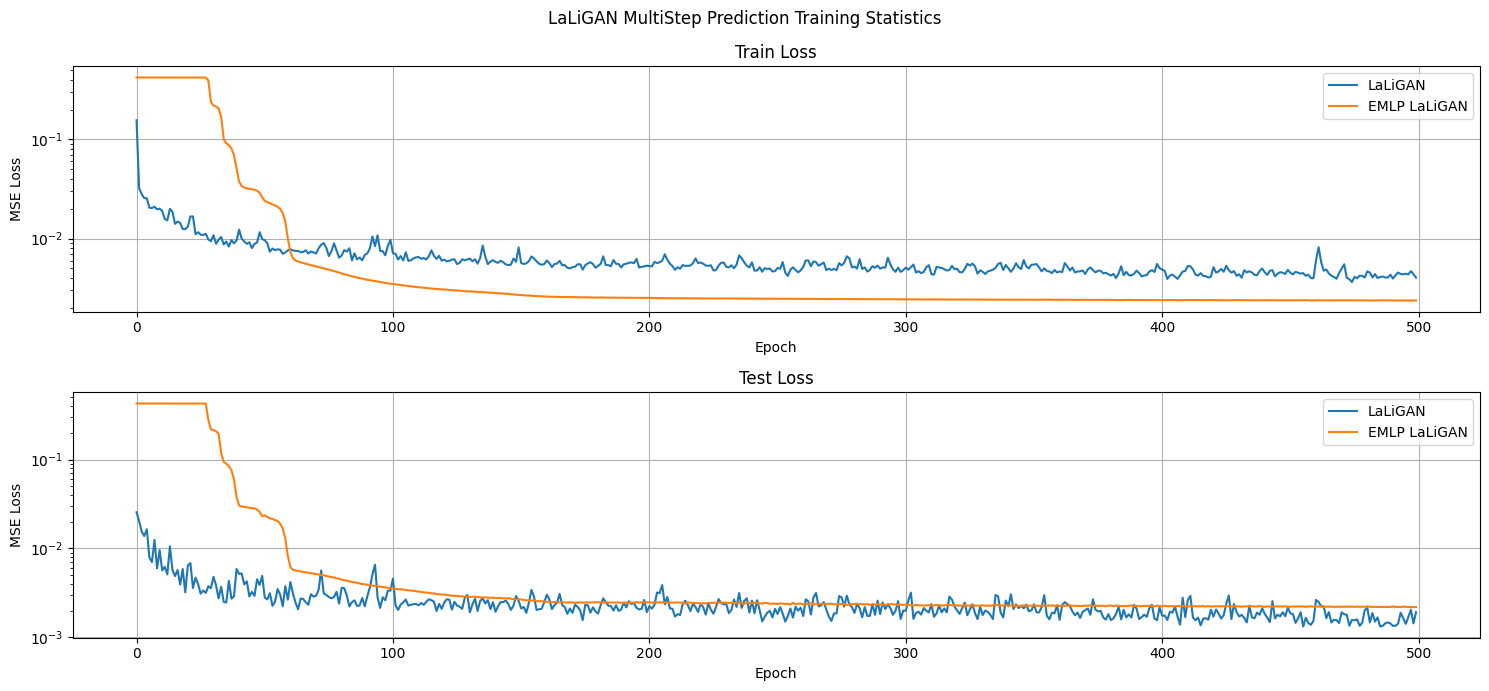

In [ ]:
# Plot training statistics
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(stats['train_loss'],label='LaLiGAN')
plt.plot(stats_emlp['train_loss'],label='EMLP LaLiGAN')
plt.yscale('log')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(stats['test_loss'],label='LaLiGAN')
plt.plot(stats_emlp['test_loss'],label='EMLP LaLiGAN')
plt.yscale('log')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.suptitle('LaLiGAN MultiStep Prediction Training Statistics')
plt.tight_layout()
plt.show()



In [15]:
print('Loading Two Body Dynamics dataset...') 
with open('data/two_body_dataset.pkl','rb') as file:
    data_dict = pickle.load(file)

test_coords = data_dict['test_coords']

Loading Two Body Dynamics dataset...


In [16]:
def forecast_emlp_laligan(model, autoencoder, last_sequence, n_steps, feature_dim, latent_dim):
    devices = jax.devices("gpu")
    if devices:
        device = devices[0]
        sequence = jax.device_put(jnp.array(last_sequence)[None, ...], device)
    else:
        sequence = jnp.array(last_sequence)[None, ...]

    # Encode the input sequence to latent space
    current_sequence_enc = autoencoder.encode(sequence, training=False)

    # JIT compile the model
    model_jit = jax.jit(model)

    # Run a forward pass to get forecast horizon
    sample_pred = model_jit(current_sequence_enc).reshape(1,-1,latent_dim)
    forecast_horizon = sample_pred.shape[1]
    # Prepare forecast array in observation space

    forecast = np.zeros((n_steps, feature_dim))



    for i in range(0, n_steps, forecast_horizon):
        next_steps_enc = model_jit(current_sequence_enc).reshape(-1,forecast_horizon,latent_dim)
        if next_steps_enc.ndim == 2:
            next_steps_enc = next_steps_enc[:, None, :]

        # Decode to observation space
        next_steps = autoencoder.decode(next_steps_enc, training=False)
        next_steps_np = np.array(next_steps[0])  # Remove batch dimension

        # Store into forecast
        steps_to_add = min(forecast_horizon, n_steps - i)
        forecast[i:i + steps_to_add] = next_steps_np[:steps_to_add]

        if i + forecast_horizon < n_steps:
            # Re-encode next steps for next iteration
            next_steps_jax = jnp.array(next_steps_np[:steps_to_add])
            if devices:
                next_steps_jax = jax.device_put(next_steps_jax, device)

            next_steps_enc = autoencoder.encode(next_steps_jax[None, ...], training=False)

            # Shift and append to form new input sequence
            current_sequence_enc = jnp.concatenate([
                current_sequence_enc[:, forecast_horizon:, :],
                next_steps_enc
            ], axis=1)

    return forecast

In [17]:
idx = np.random.choice(range(0,len(test_coords)))
last_sequence = test_coords[idx,:input_timesteps,:]
n_steps = len(test_coords[0,:,:])-len(last_sequence)

forecast = forecast_nn_laligan(regressor,autoencoder,last_sequence,n_steps,n_dim,latent_dim)
forecast_e = forecast_emlp_laligan(model_emlp,jax_autoencoder,last_sequence,n_steps,n_dim,latent_dim)

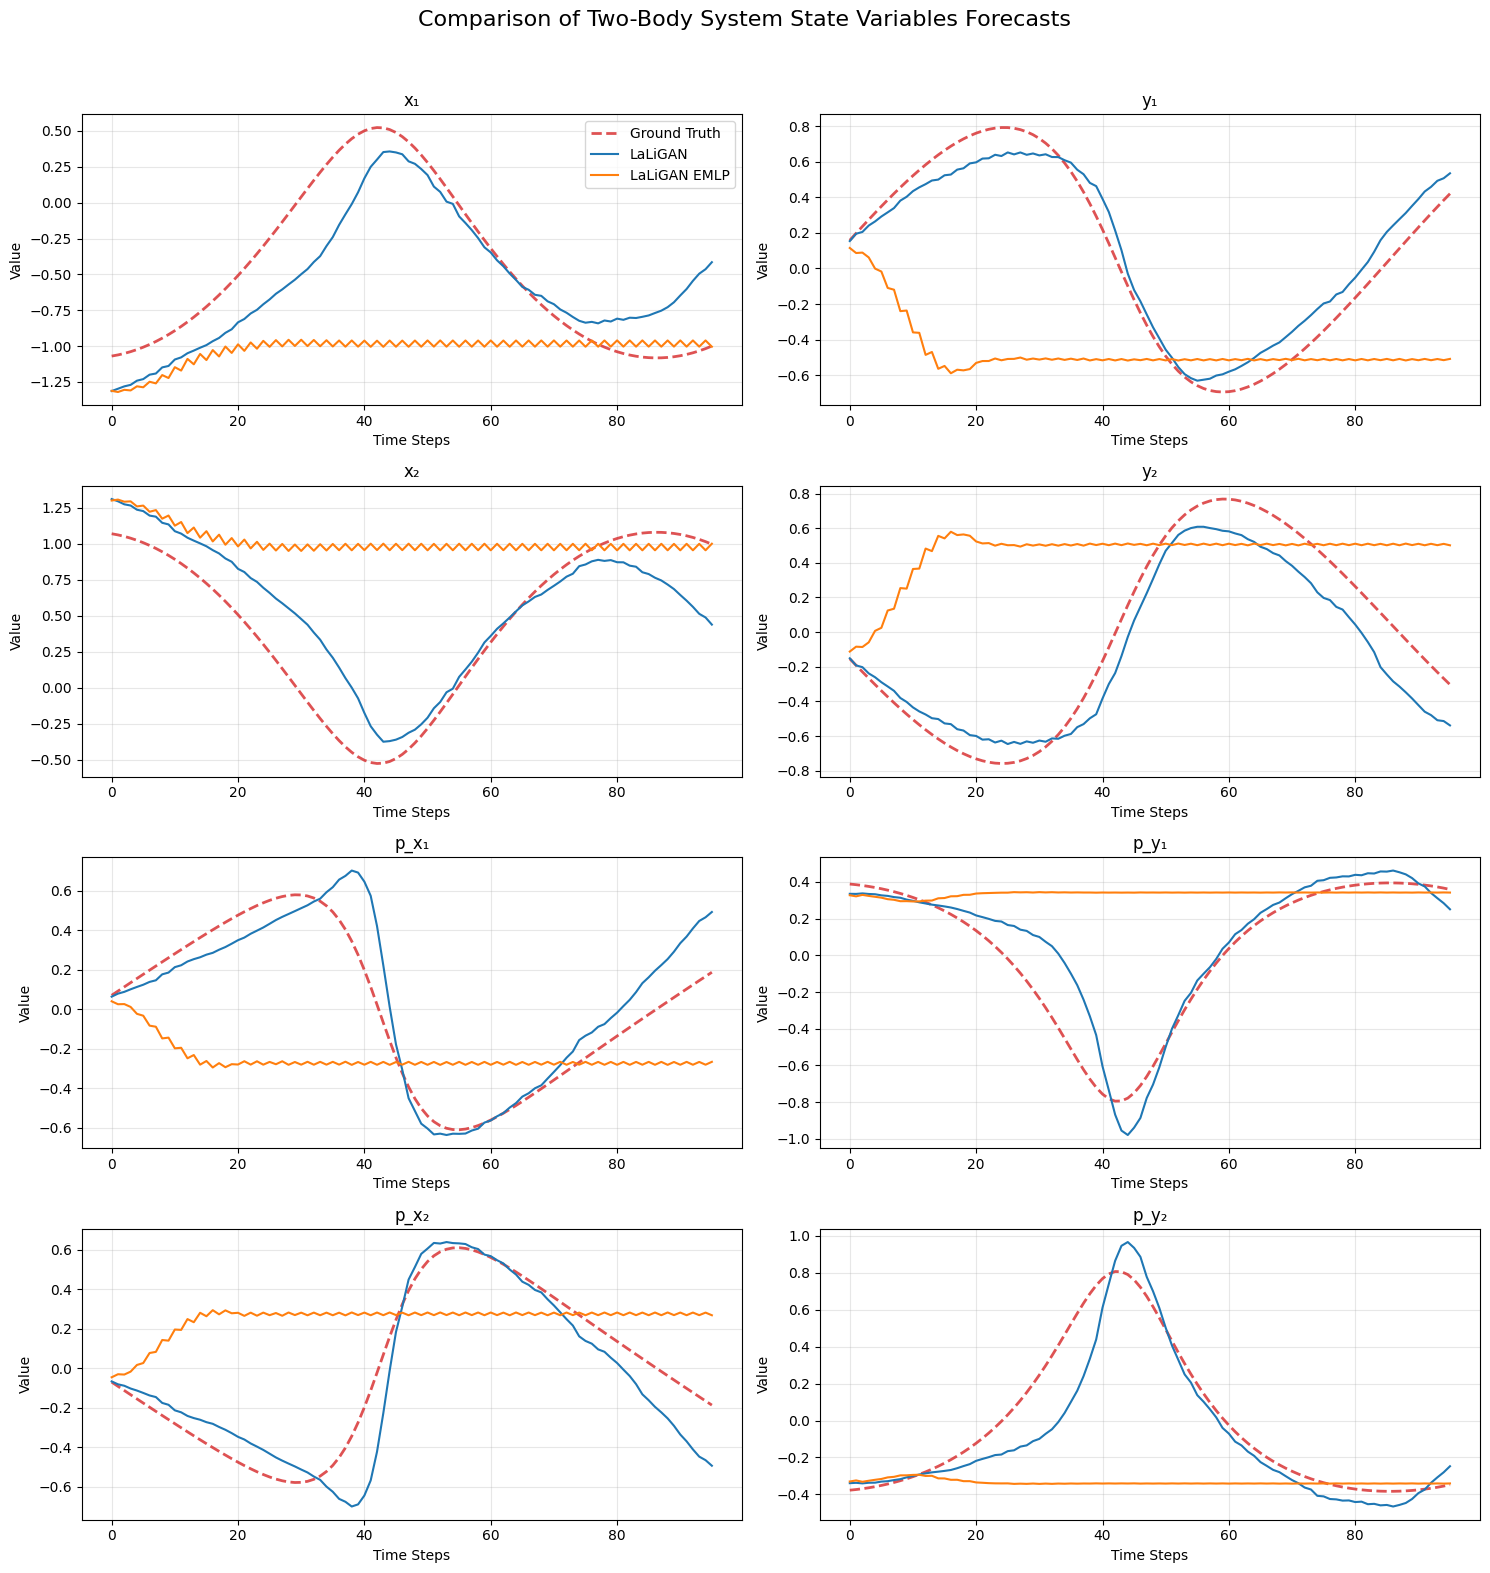

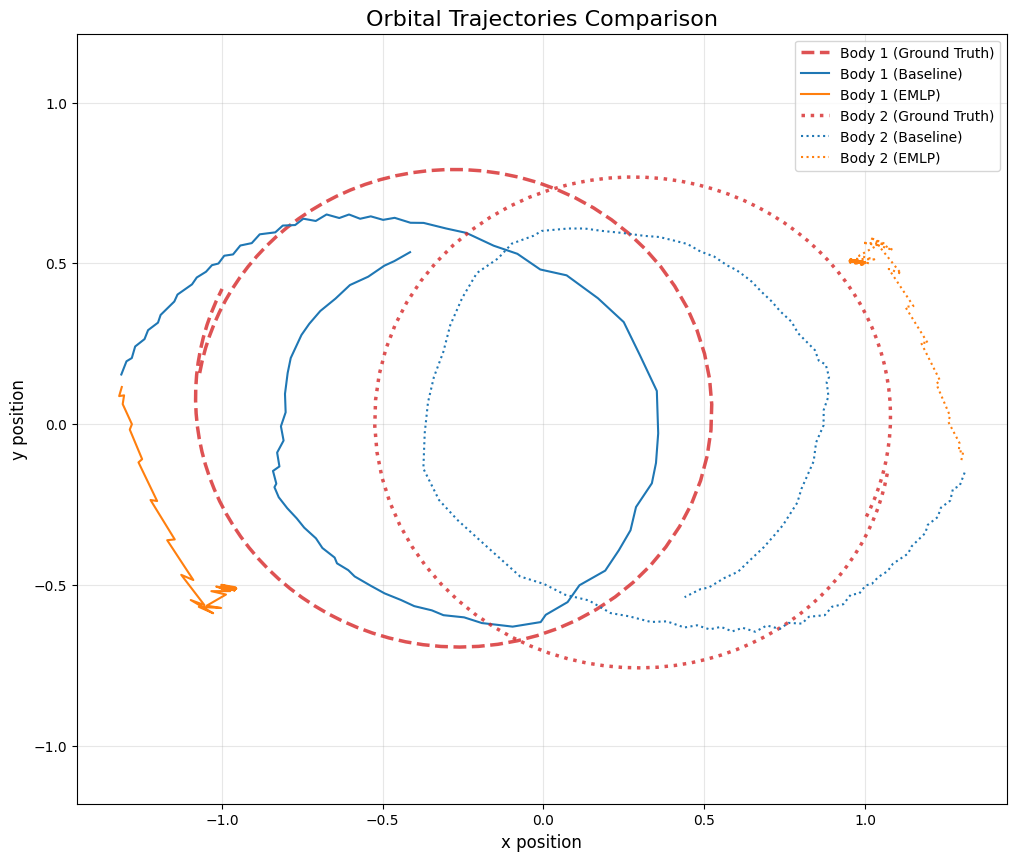

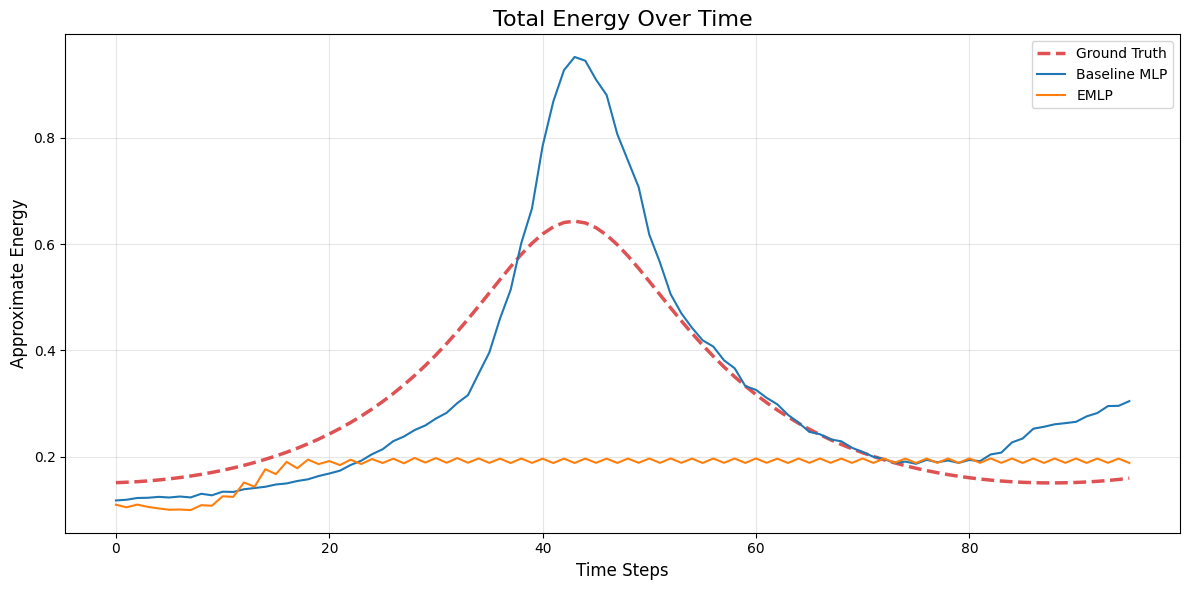

In [18]:
def plot_forecast_comparison(forecast, forecast_e, test_coords, input_timesteps):
    """
    Plot all 8 variables from four different forecast models for comparison.
    
    Parameters:
    -----------
    forecast : array - Baseline model predictions
    forecast_e : array - EMLP model predictions
    test_coords : array - Ground truth coordinates
    input_timesteps : int - Number of initial timesteps used for prediction
    """
    # Extract ground truth data for comparison
    n_steps = len(forecast)
    ground_truth = test_coords[0, input_timesteps:input_timesteps+n_steps]
    
    # Create time steps for x-axis
    time_steps = np.arange(n_steps)
    
    # Variable names for labels (assuming a two-body system like in the example)
    var_names = ['x₁', 'y₁', 'x₂', 'y₂', 'p_x₁', 'p_y₁', 'p_x₂', 'p_y₂']
    
    # Define a consistent color scheme
    colors = {
        'ground_truth': '#d62728',  # Red
        'baseline': '#1f77b4',      # Blue
        'aug_vanilla': '#9467bd',   # Purple
        'aug_improved': '#2ca02c',  # Green
        'emlp': '#ff7f0e'           # Orange
    }
    
    # Create a 4x2 grid of subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 16))
    fig.suptitle('Comparison of Two-Body System State Variables Forecasts', fontsize=16)
    
    # Plot all 8 variables
    for i, ax in enumerate(axes.flat):
        # Plot predictions from all models
        ax.plot(time_steps, ground_truth[:, i], '--', color=colors['ground_truth'], 
                label='Ground Truth', linewidth=2, alpha=0.8)
        ax.plot(time_steps, forecast[:, i], '-', color=colors['baseline'], 
                label='LaLiGAN', linewidth=1.5)
        ax.plot(time_steps, forecast_e[:, i], '-', color=colors['emlp'], 
                label='LaLiGAN EMLP', linewidth=1.5)
        
        ax.set_title(f'{var_names[i]}', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Only add legend to the first plot to save space
        if i == 0:
            ax.legend(fontsize=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
    
    # Plot orbital trajectories of both bodies
    plt.figure(figsize=(12, 10))
    plt.title('Orbital Trajectories Comparison', fontsize=16)
    
    # Body 1 trajectories (positions x₁, y₁)
    plt.plot(ground_truth[:, 0], ground_truth[:, 1], '--', color=colors['ground_truth'], 
             label='Body 1 (Ground Truth)', linewidth=2.5, alpha=0.8)
    plt.plot(forecast[:, 0], forecast[:, 1], '-', color=colors['baseline'], 
             label='Body 1 (Baseline)', linewidth=1.5)
    plt.plot(forecast_e[:, 0], forecast_e[:, 1], '-', color=colors['emlp'], 
             label='Body 1 (EMLP)', linewidth=1.5)
    
    # Body 2 trajectories (positions x₂, y₂)
    plt.plot(ground_truth[:, 2], ground_truth[:, 3], ':', color=colors['ground_truth'], 
             label='Body 2 (Ground Truth)', linewidth=2.5, alpha=0.8)
    plt.plot(forecast[:, 2], forecast[:, 3], ':', color=colors['baseline'], 
             label='Body 2 (Baseline)', linewidth=1.5)
    plt.plot(forecast_e[:, 2], forecast_e[:, 3], ':', color=colors['emlp'], 
             label='Body 2 (EMLP)', linewidth=1.5)
    
    plt.xlabel('x position', fontsize=12)
    plt.ylabel('y position', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend(fontsize=10, loc='best')
    
    # Plot energy conservation (assuming Hamiltonian system)
    plt.figure(figsize=(12, 6))
    plt.title('Total Energy Over Time', fontsize=16)
    
    # Calculate approximate energy (kinetic + potential) if this is a Hamiltonian system
    # For simplicity, assuming masses are 1 and only considering kinetic energy from momenta
    # E ≈ (p_x₁² + p_y₁² + p_x₂² + p_y₂²)/2
    def approx_energy(data):
        return 0.5 * (data[:, 4]**2 + data[:, 5]**2 + data[:, 6]**2 + data[:, 7]**2)
    
    plt.plot(time_steps, approx_energy(ground_truth), '--', color=colors['ground_truth'], 
             label='Ground Truth', linewidth=2.5, alpha=0.8)
    plt.plot(time_steps, approx_energy(forecast), '-', color=colors['baseline'], 
             label='Baseline MLP', linewidth=1.5)
    plt.plot(time_steps, approx_energy(forecast_e), '-', color=colors['emlp'], 
             label='EMLP', linewidth=1.5)
    
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Approximate Energy', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10, loc='best')
    
    plt.tight_layout()
    plt.show()

# Call the function with your data
# plot_forecast_comparison(
#     forecast[:50,:], 
#     forecast_aug_v[:50,:], 
#     forecast_aug_i[:50,:], 
#     forecast_e[:50,:], 
#     test_coords[:50,:], 
#     input_timesteps, 
# )

plot_forecast_comparison(
    forecast, 
    forecast_e, 
    test_coords, 
    input_timesteps, 
)

In [ ]:
## Computing Error metrics 

n = 10  # Number of samples
indices = np.random.choice(test_coords.shape[0], min(n,test_coords.shape[0]), replace=False)

def mse_comp(arr1,arr2):
    assert arr1.shape == arr2.shape 

    squared_diff = (arr1-arr2)**2 
    return np.mean(squared_diff)

mse = {
    'LaLiGAN':[],
    'EMLP LaLiGAN':[],
}

for i,idx in enumerate(indices):
    print(f'Trial {i+1}')
    sim = test_coords[idx,input_timesteps:,:]

    last_sequence = test_coords[idx,:input_timesteps,:]
    n_steps = len(test_coords[idx,:,:])-len(last_sequence)

    nn_forecast = forecast_nn_laligan(regressor,autoencoder,last_sequence,n_steps,n_dim,latent_dim)
    emlp_forecast = forecast_emlp_laligan(model_emlp,jax_autoencoder,last_sequence,n_steps,n_dim,latent_dim)


    mse['LaLiGAN'].append(mse_comp(sim,nn_forecast))
    mse['EMLP LaLiGAN'].append(mse_comp(sim,emlp_forecast))




Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10


In [20]:
for k in mse.keys():
    print(f'{k} : {np.mean(mse[k])}')

LaLiGAN : 0.3150063468476983
EMLP LaLiGAN : 0.5377974898237593
